In [1]:
from collections import defaultdict
from pprint import pprint
import os
import shlex
import csv
from typing import Any
from typing import Callable
from typing import DefaultDict
from typing import Dict
from typing import List
from typing import NoReturn
from typing import Set
from typing import Tuple
from typing import Union


import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

%load_ext blackcellmagic

# Global Parameters

In [2]:
# Colors that will be used to represent distributions in Figures
# Keep this here as it's used in various functions
distro_colors = {
    "ubuntu": "xkcd:orangered",
    "debian": "xkcd:teal",
    "centos": "xkcd:blue",
    "alpine": "xkcd:lightblue",
}

# Introduction

This notebook analyzes the output of Anchore, Clair and Vuls on BIDS app and Boutiques container images. The data is structured as follows:

* `images.csv`: list of tested images, with distribution, version, and number of packages.
* `Data/<scanner>`: output of scanner <scanner>, contains subdirectories for update, minification and original scanning results, which further have subdirectories for BIDS and Boutiques images, with one output file for each container image.
    
The remainder of this notebook parses this data and plots the figures used in the paper.

# Parsing of result files

First, we read the list of Docker images, distributions and number of packages.

In [3]:
with open("./images.csv", "r") as fin:
    images = {
        line.split(",")[0]: (line.split(",")[1], line.split(",")[2].strip())
        for line in fin.readlines()[1:]
    }

print(f"Number of images: {len(images)}")
print("List of images:")
images

Number of images: 38
List of images:


{'gkiar/onevoxel:v0.3.0rc2': ('alpine:3.7.1', '71'),
 'bids/rshrf:1.0.1': ('alpine:3.8.4', '35'),
 'gkiar/mask2boundary:v0.1.0': ('alpine:3.9.0', '61'),
 'bids/broccoli:v1.0.0': ('centos:6', '253'),
 'mcin/docker-fsl:latest': ('centos:7', '145'),
 'bids/nipypelines:0.3.0': ('debian:8', '157'),
 'bids/baracus': ('ubuntu:14.04', '218'),
 'bids/rs_signal_extract:0.1': ('ubuntu:16.04', '241'),
 'bids/antscorticalthickness:v2.2.0-1': ('ubuntu:17.04', '291'),
 'bids/afni_proc': ('ubuntu:17.10', '277'),
 'mcin/ica-aroma:latest': ('centos:7', '159'),
 'bids/magetbrain': ('ubuntu:18.04', '167'),
 'mcin/qeeg:latest': ('centos:7', '171'),
 'bt5e/ants:latest': ('centos:7', '188'),
 'bigdatalabteam/hcp-prefreesurfer:exec-centos7-fslbuild-centos5-latest': ('centos:7',
  '240'),
 'bigdatalabteam/hcp-prefreesurfer:exec-centos7.freesurferbuild-centos4-latest': ('centos:7',
  '254'),
 'bids/brainiak-srm': ('ubuntu:16.04', '258'),
 'gkiar/dwipreproc_fsl-5.0.11_minified': ('ubuntu:16.04', '269'),
 'bids/m

Now, we read the list of Singularity images,distributions and number of packages.

In [4]:
with open("./SingularityImages.csv", "r") as fin:
    singularity_images = {
        line.split(",")[0]: (line.split(",")[1], line.split(",")[2].strip())
        for line in fin.readlines()[1:]
    }

print(f"Number of images: {len(singularity_images)}")
print("List of images:")
singularity_images

Number of images: 6
List of images:


{'c3genomics/genpipes': ('centos:7', '222'),
 'bioinformatics-group/aqua-singularity-recipe': ('debian:9', '164'),
 'MontrealSergiy/BEst': ('ubuntu:16.04', '257'),
 'aces/cbrain-containers-recipes:fsl_v6.0.1': ('ubuntu:16.04', '220'),
 'shots47s/bids-freesurfer-6.0': ('ubuntu:14.04', '302'),
 'shots47s/bids-fmriprep-1.2.3': ('ubuntu:16.04', '446')}

We will analyze the scanning results of these images.

## Anchore

Here we parse the vulnerabilities detected by Anchore, and summarize them in a DataFrame:

In [5]:
data_dir = "./Data/Anchore_Results/Original"

anchore_files: Dict[str, Tuple[str, str, str]] = {}

# Find vulnerability file by image name
for image in images:

    prefix, image_name = image.split("/")

    # Check if image is from BIDS or Boutiques (heuristic)
    if prefix.upper() != "BIDS" and prefix != "poldracklab":
        prefix = "Boutiques"
    else:
        prefix = "BIDS"
    if ":" in image_name:
        image_alias, version = image_name.split(":")
    else:
        image_alias = image_name
        version = "latest"

    # Handle ndmg manually
    if image == "bids/ndmg:v0.1.0":
        prefix = "Boutiques"
        image_alias = "ndmg"
        version = "v0.1.0"

    # Handle fmriprep manually
    if image == "poldracklab/fmriprep:1.2.3":
        prefix = "Boutiques"
        image_alias = "fmriprep"
        version = "1.2.3"

    # Handle hcp-prefreesurfer manually
    if image_alias == "hcp-prefreesurfer":
        if version == "exec-centos7-fslbuild-centos5-latest":
            image_alias = "hcp-prefreesurfer1"
        if version == "exec-centos7.freesurferbuild-centos4-latest":
            image_alias = "hcp-prefreesurfer2"

    file_name = os.path.join(data_dir, prefix, image_alias) + ".csv"
    if not os.path.isfile(file_name):
        print(f"File not found: {file_name}")

    anchore_files[image] = (file_name, images[image][0], images[image][1])

In [6]:
anchore_files["poldracklab/fmriprep:1.2.3"]
# Each entry in anchore_files is a triple: (file_name, container_image, n_packages)

('./Data/Anchore_Results/Original/Boutiques/fmriprep.csv',
 'ubuntu:16.04',
 '441')

Let's now write functions to get results of minification and update

In [7]:
def get_after_updates(fname):
    if not os.path.isfile(fname):
        return None
    else:
        with open(fname, "r") as fin:
          lines = fin.readlines()
        cves = {
        shlex.split(line)[0] for line in lines[1:]
         }
        return len(cves)
  



In [8]:
def get_after_minification(fname):
    if not os.path.isfile(fname):
        return None
    else:
        with open(fname, "r") as fin:
          lines = fin.readlines()
        cves = {
        shlex.split(line)[0] for line in lines[1:]
         }
        return len(cves)
  

In [9]:
def get_after_both(fname):
    if not os.path.isfile(fname):
        return None
    else:
        with open(fname, "r") as fin:
          lines = fin.readlines()
        cves = {
        shlex.split(line)[0] for line in lines[1:]
         }
        return len(cves)

We're now ready to build our summary DataFrame:

In [10]:
def get_summary(
    dist_files: Dict[str, Tuple[str, str, str]],
    get_n_unique_vul: Callable[..., int],
    severity: bool = True,
    update_and_minif: bool = True,
    singularity:bool = False,
) -> pd.DataFrame:
    """
    Parameters
    ----------
    dist_files : Dict[str, Tuple[str, str, str]]
        dictionary associating scanner output files with image names and versions. `Example: anchore_files`.
    get_n_unique_vul : Callable[..., List[str]]
        a function with two parameters, 'severity' and 'lines', where 'severity' is a vulnerability severity
        (ex: 'High'), and 'lines' is the list of lines found in a scanner output. Returns the number of
        vulnerabilities of severity 'severity' in 'lines'.
    severity : bool
        True if summary has to include vulnerability counts by severity
    update_and_minif : bool
        True if summary has to include vulnerability counts after update and minification (Anchore only)
    singularity : bool
        True if summary is for Singularity images

    Returns
    -------
    summary : pd.DataFrame
        a data frame with vulnerability counts by image
    """

    # Columns of the dataframe
    df_columns = [
        "Abbrv",
        "Image",
        "Distribution",
        "Version",
        "Color",  # image and parameters
        "Negligible",
        "Low",
        "Medium",
        "High",
        "Critical",  # vulnerabilities by severity
        "Total",
        "Total_after_update",
        "Total_after_minification",
        "Total_after_both",
        "File",
    ]  # total vulnerabilities

    summary = pd.DataFrame(columns=df_columns)

    for i, image in enumerate(dist_files):

        # Read scanner output
        filename = dist_files[image][0]

        with open(filename, "r") as fin:
            if severity:
                lines = fin.readlines()
            else:
                lines = [line.split() for line in fin]

        if severity:
            negligible = get_n_unique_vul("Negligible", lines)
            low = get_n_unique_vul("Low", lines)
            medium = get_n_unique_vul("Medium", lines)
            high = get_n_unique_vul("High", lines)
            critical = get_n_unique_vul("Critical", lines)
            unknown = get_n_unique_vul("Unknown", lines)
            total = negligible + low + medium + high + critical + unknown
        else:
            negligible = get_n_unique_vul("NEGLIGIBLE", lines)
            low = get_n_unique_vul("LOW", lines)
            medium = get_n_unique_vul("MEDIUM", lines)
            high = get_n_unique_vul("HIGH", lines)
            critical = get_n_unique_vul("CRITICAL", lines)
            unknown = get_n_unique_vul("Unknown", lines)
            total = negligible + low + medium + high + critical + unknown

        # Total number of packages
        packages = int(dist_files[image][2])
        
        if singularity:
            abbrv = image.split("/")[1]
            ascii = 109 + i
            if ascii > 90:
                ascii += 6
            abbrv = chr(ascii) +chr(42)
            
        else:

            # Define abbreviations to be used in figures
            abbrv = image.split("/")[1]
            if ":" in abbrv:
                abbrv = abbrv.split(":")[0]
            collisions = ["ndmg", "hcp-prefreesurfer", "fmriprep"]
            if abbrv in collisions:
                abbrv += str(i % 2)
            ascii = 65 + i
            if ascii > 90:
                ascii += 6
            abbrv = chr(ascii) + " "

        # Get vulnerabilities after update and minification
        after_update: Union[int, None] = None
        after_minification: Union[int, None] = None
        after_both: Union[int, None] = None
        if update_and_minif:
            update_file = filename.replace("Original", "Updated")
            minify_file = filename.replace("Original","Minified")
            hybrid_file = filename.replace("Original","HybridApproach")
            after_update = get_after_updates(update_file)
            after_minification = get_after_minification(minify_file)
            after_both = get_after_both(hybrid_file)

            if (
                image == "bids/afni_proc"
            ):  # npackage-based calculations doesn't work here
                after_update = None
                after_minification = None
                after_both = None
            if (image == "bids/ndmg:v0.1.0"): # it is not minified and npackage-based calculations doesn't work here
                after_minification = None
                after_both = None
        if singularity:
            version = singularity_images[image][0].split(":")[1]
            distribution = singularity_images[image][0].split(":")[0]
        else:
            
            version = images[image][0].split(":")[1]
            distribution = images[image][0].split(":")[0]
        summary = summary.append(
            {
                "Image": image,
                "Abbrv": abbrv,
                "Distribution": distribution,
                "Version": version,
                "Color": distro_colors[distribution],
                "Packages": packages,
                "Negligible": negligible,
                "Unknown": unknown,
                "Low": low,
                "Medium": medium,
                "High": high,
                "Critical": critical,
                "Total": total,
                "Total_after_update": after_update,
                "Total_after_minification": after_minification,
                "Total_after_both": after_both,
                "File": filename,
            },
            ignore_index=True,
        )
    summary = summary.sort_values("Total", ascending=False)

    return summary

We can now call this function on Anchore's output:

In [11]:
def get_n_unique_vul_anchore(status: str, lines: List[str]) -> int:
    cves = {
        shlex.split(line)[0] for line in lines[1:] if shlex.split(line)[2] == status
    }
    return len(cves)


anchore_summary = get_summary(anchore_files, get_n_unique_vul_anchore)

print(
    (
        f"Number of Images: {len(anchore_summary)}"
        "\n"
        f"Average number of vulnerabilities per image: {anchore_summary['Total'].mean():.3f}"
        "\n"
        f"Median number of vulnerabilities per image: {anchore_summary['Total'].median():.3f}"
    )
)

anchore_summary

Number of Images: 38
Average number of vulnerabilities per image: 503.211
Median number of vulnerabilities per image: 411.500


Abbrv                                              Image Distribution  \
36    k                                 bids/hyperalignment       ubuntu   
37    l                                           bids/niak       ubuntu   
33    h                    bids/fibredensityandcrosssection       ubuntu   
32    g                                           bids/ndmg       ubuntu   
31    f                                    bids/ndmg:v0.1.0       ubuntu   
35    j                                 bids/oppni:v0.7.0-1       ubuntu   
16    Q                                   bids/brainiak-srm       ubuntu   
30    e                               bids/tracula:v6.0.0-4       ubuntu   
7     H                          bids/rs_signal_extract:0.1       ubuntu   
29    d                                        bids/example       ubuntu   
34    i                                bids/cpac:v1.0.1a_22       ubuntu   
18    S                             bids/mindboggle:0.0.4-1       debian   
5     F                              bids/nipypelines:0.3.0       debian   
13    N                                    bt5e/ants:latest       centos   
26    a                          poldracklab/fmriprep:1.2.3       ubuntu   
25    Z                        bids/hcppipelines:v3.17.0-18       debian   
27    b                       poldracklab/fmriprep:unstable       ubuntu   
28    c                                 bids/dparsf:v4.3.12       ubuntu   
24    Y                            poldracklab/mriqc:0.15.0       ubuntu   
17    R                gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   
20    U                                     bids/freesurfer       ubuntu   
8     I                 bids/antscorticalthickness:v2.2.0-1       ubuntu   
21    V                             bids/mrtrix3_connectome       ubuntu   
15    P   bigdatalabteam/hcp-prefreesurfer:exec-centos7....       centos   
14    O   bigdatalabteam/hcp-prefreesurfer:exec-centos7-...       centos   
3     D                                bids/broccoli:v1.0.0       centos   
22    W                                            bids/spm       ubuntu   
23    X                                      bids/aa:v0.2.0       ubuntu   
4     E                              mcin/docker-fsl:latest       centos   
10    K                               mcin/ica-aroma:latest       centos   
6     G                                        bids/baracus       ubuntu   
19    T                              camarasu/creaphase:0.3       centos   
12    M                                    mcin/qeeg:latest       centos   
11    L                                     bids/magetbrain       ubuntu   
9     J                                      bids/afni_proc       ubuntu   
2     C                          gkiar/mask2boundary:v0.1.0       alpine   
1     B                                    bids/rshrf:1.0.1       alpine   
0     A                            gkiar/onevoxel:v0.3.0rc2       alpine   

   Version           Color Negligible  Low Medium High Critical Total  \
36   16.04  xkcd:orangered        100  594    971   50        1  1717   
37   16.04  xkcd:orangered        106  557    783   35        1  1482   
33   14.04  xkcd:orangered         79  427    545   34        1  1086   
32   14.04  xkcd:orangered         79  387    448   20        0   934   
31   14.04  xkcd:orangered         79  387    448   20        0   934   
35   14.04  xkcd:orangered         76  371    438   27        1   913   
16   16.04  xkcd:orangered         54  365    431   46        1   897   
30   14.04  xkcd:orangered         76  360    415   22        1   874   
7    16.04  xkcd:orangered         61  378    383   44        1   867   
29   14.04  xkcd:orangered         76  358    385   19        0   838   
34   16.04  xkcd:orangered         56  348    276   18        0   698   
18       8       xkcd:teal        165   61    279  159        0   671   
5        8       xkcd:teal        130   72    266  162        0   641   
13       7      

## Stools

Here we parse the vulnerabilities detected by Stools, and summarize them in a DataFrame:

In [12]:
data_dir = "./Data/Stools_Results"

stools_files: Dict[str, Tuple[str, str, str]] = {}

# Find vulnerability file by image name
for image in singularity_images:

    prefix, image_name = image.split("/")
    file_name = os.path.join(data_dir,image_name) + ".txt"
    if not os.path.isfile(file_name):
        print(f"File not found: {file_name}")

    stools_files[image] = (file_name, singularity_images[image][0], singularity_images[image][1])

In [13]:
def get_n_unique_vul_stools(status: str, lines: List[str]) -> int:
    cves = {
        (shlex.split(line)[0]) for line in lines if (len(line.split())==2 and status in line) 
    }
    return len(cves)


stools_summary = get_summary(stools_files, get_n_unique_vul_stools,severity=True, update_and_minif=False,singularity=True)

print(
    (
        f"Number of Images: {len(stools_summary)}"
        "\n"
        f"Average number of vulnerabilities per image: {stools_summary['Total'].mean():.3f}"
        "\n"
        f"Median number of vulnerabilities per image: {stools_summary['Total'].median():.3f}"
    )
)

stools_summary

Number of Images: 6
Average number of vulnerabilities per image: 189.833
Median number of vulnerabilities per image: 200.000


Abbrv                                         Image Distribution Version  \
5    x*                  shots47s/bids-fmriprep-1.2.3       ubuntu   16.04   
3    v*     aces/cbrain-containers-recipes:fsl_v6.0.1       ubuntu   16.04   
4    w*                  shots47s/bids-freesurfer-6.0       ubuntu   14.04   
0    s*                           c3genomics/genpipes       centos       7   
2    u*                           MontrealSergiy/BEst       ubuntu   16.04   
1    t*  bioinformatics-group/aqua-singularity-recipe       debian       9   

            Color Negligible  Low Medium High Critical Total  \
5  xkcd:orangered         31  256    127    7        0   421   
3  xkcd:orangered         23  164     19    0        0   206   
4  xkcd:orangered         31  126     45    1        0   203   
0       xkcd:blue          0   28     53  116        0   197   
2  xkcd:orangered         25   61     19    0        0   105   
1       xkcd:teal          5    0      1    1        0     7   

  Total_after_update Total_after_minification Total_after_both  \
5               None                     None             None   
3               None                     None             None   
4               None                     None             None   
0               None                     None             None   
2               None                     None             None   
1               None                     None             None   

                                                File  Packages  Unknown  
5      ./Data/Stools_Results/bids-fmriprep-1.2.3.txt     446.0      0.0  
3  ./Data/Stools_Results/cbrain-containers-recipe...     220.0      0.0  
4      ./Data/Stools_Results/bids-freesurfer-6.0.txt     302.0      0.0  
0                 ./Data/Stools_Results/genpipes.txt     222.0      0.0  
2                     ./Data/Stools_Results/BEst.txt     257.0      0.0  
1  ./Data/Stools_Results/aqua-singularity-recipe.txt     164.0      0.0

## Ideas about attacks

To have a better idea of the type of attacks that could exploit these vulnerabilities, we can list the critical vulnerabilities:

In [14]:
# List unique critical CVEs
file_names = [anchore_files[image][0] for image in images]
critical: Set[Tuple[str, str]] = set()

for file_name in file_names:
    with open(file_name, "r") as f:
        lines = f.readlines()

    lines = [shlex.split(line) for line in lines][1:]
    critical = critical.union({l[0] for l in lines if l[2] == "Critical"})

for c in critical:
    print(c)

CVE-2017-5754
CVE-2016-1950
CVE-2015-5229
CVE-2015-7182
CVE-2015-7181
CVE-2017-5461
CVE-2015-7183
CVE-2015-7547


These CVE's give interesting insights on how containers could be attacked when deployed on HPC clusters.

## Clair

To get the summary of vulnerabilities reported by Clair, we generate the output file names, and call function get_summary to generate a data frame in the same format as for Anchore:

In [15]:
clair_files: Dict[str, Tuple[str, str, str]] = {}
for image in images:
    clair_files[image] = (
        anchore_files[image][0].replace("Anchore", "Clair").replace("csv", "txt"),
        anchore_files[image][1],
        anchore_files[image][2],
    )

for f in clair_files:
    if not os.path.isfile(clair_files[f][0]):
        print(f"Missing file: {clair_files[f][0]}")

In [16]:
def get_n_unique_vul_clair(status, lines):
    # print(len(lines))
    cves = []
    check = False
    for line in lines:
        if line.startswith("+"):
            check = True
            break
    if not check:
        for line in lines:
            if status in line:
                cves.append(line.split()[0])

    else:
        rows = [[str(x) for x in line.split("|")[:-1]] for line in lines]
        cols = [list(col) for col in zip(*rows)]
        for row in rows:
            if len(row) > 1:
                split_cve = row[2].split()
                if len(split_cve) > 1:
                    only_cve = split_cve[1]
                    severity = split_cve[0]
                    if severity == status:
                        cves.append(only_cve)
    return len(set(cves))


clair_summary = get_summary(
    clair_files, get_n_unique_vul_clair, severity=True, update_and_minif=False
)


print(
    (
        f"Number of images: {len(clair_summary)}"
        "\n"
        f"Average number of vulnerabilities per image: {clair_summary['Total'].mean():.3f}"
        "\n"
        f"Median number of vulnerabilities per image: {clair_summary['Total'].median():.3f}"
    )
)

clair_summary

Number of images: 38
Average number of vulnerabilities per image: 437.316
Median number of vulnerabilities per image: 297.000


Abbrv                                              Image Distribution  \
37    l                                           bids/niak       ubuntu   
36    k                                 bids/hyperalignment       ubuntu   
18    S                             bids/mindboggle:0.0.4-1       debian   
5     F                              bids/nipypelines:0.3.0       debian   
25    Z                        bids/hcppipelines:v3.17.0-18       debian   
33    h                    bids/fibredensityandcrosssection       ubuntu   
31    f                                    bids/ndmg:v0.1.0       ubuntu   
32    g                                           bids/ndmg       ubuntu   
28    c                                 bids/dparsf:v4.3.12       ubuntu   
35    j                                 bids/oppni:v0.7.0-1       ubuntu   
30    e                               bids/tracula:v6.0.0-4       ubuntu   
29    d                                        bids/example       ubuntu   
13    N                                    bt5e/ants:latest       centos   
34    i                                bids/cpac:v1.0.1a_22       ubuntu   
16    Q                                   bids/brainiak-srm       ubuntu   
7     H                          bids/rs_signal_extract:0.1       ubuntu   
26    a                          poldracklab/fmriprep:1.2.3       ubuntu   
27    b                       poldracklab/fmriprep:unstable       ubuntu   
24    Y                            poldracklab/mriqc:0.15.0       ubuntu   
15    P   bigdatalabteam/hcp-prefreesurfer:exec-centos7....       centos   
14    O   bigdatalabteam/hcp-prefreesurfer:exec-centos7-...       centos   
17    R                gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   
22    W                                            bids/spm       ubuntu   
23    X                                      bids/aa:v0.2.0       ubuntu   
6     G                                        bids/baracus       ubuntu   
20    U                                     bids/freesurfer       ubuntu   
3     D                                bids/broccoli:v1.0.0       centos   
10    K                               mcin/ica-aroma:latest       centos   
4     E                              mcin/docker-fsl:latest       centos   
21    V                             bids/mrtrix3_connectome       ubuntu   
19    T                              camarasu/creaphase:0.3       centos   
12    M                                    mcin/qeeg:latest       centos   
11    L                                     bids/magetbrain       ubuntu   
8     I                 bids/antscorticalthickness:v2.2.0-1       ubuntu   
9     J                                      bids/afni_proc       ubuntu   
2     C                          gkiar/mask2boundary:v0.1.0       alpine   
1     B                                    bids/rshrf:1.0.1       alpine   
0     A                            gkiar/onevoxel:v0.3.0rc2       alpine   

   Version           Color Negligible  Low Medium High Critical Total  \
37   16.04  xkcd:orangered         91  587    680    8        0  1366   
36   16.04  xkcd:orangered         76  484    755   12        0  1327   
18       8       xkcd:teal        164  171    403  212        0   955   
5        8       xkcd:teal        131  161    368  208        0   878   
25       8       xkcd:teal        192  171    353  147        0   873   
33   14.04  xkcd:orangered         62  345    435    7        0   849   
31   14.04  xkcd:orangered         62  297    394    5        0   758   
32   14.04  xkcd:orangered         62  297    393    5        0   757   
28   14.04  xkcd:orangered         65  293    387    5        0   750   
35   14.04  xkcd:orangered         60  279    353    6        0   698   
30   14.04  xkcd:orangered         59  269    332    4        0   664   
29   14.04  xkcd:orangered         59  269    331    4        0   663   
13       7       xkcd:blue          0   36    179  378        7   600   
34   16.04  xkcd

## Vuls

Now, we generate the same type of summary for Vuls:

In [17]:
vuls_files: Dict[str, Tuple[str, str, str]] = {}

for image in images:
    if "ubuntu:17" in images[image][0]:
        continue  # vuls doesn't support ubuntu 17
    file_name = anchore_files[image][0].replace("Anchore", "Vuls")

    if os.path.isfile(file_name):
        vuls_files[image] = (file_name, images[image][0], images[image][1])
    else:
        print(f"Missing file: {file_name}")

In [18]:
def get_n_unique_vul_vuls(status, lines):
    cves = []
    for line in lines:
        if (line[0].startswith("CVE")) or (line[0].startswith("TEMP")):
            if status in line[3]:
                cves.append(line[0])
    return len(cves)


vuls_summary = get_summary(
    vuls_files, get_n_unique_vul_vuls, severity=False, update_and_minif=False
)

print(
    (
        f"Number of Images: {len(vuls_summary)}"
        "\n"
        f"Average number of vulnerabilities per image: {vuls_summary['Total'].mean():.3f}"
        "\n"
        f"Median number of vulnerabilities per image: {vuls_summary['Total'].median():.3f}"
    )
)

vuls_summary

Number of Images: 36
Average number of vulnerabilities per image: 427.528
Median number of vulnerabilities per image: 334.000


Abbrv                                              Image Distribution  \
34    i                                 bids/hyperalignment       ubuntu   
35    j                                           bids/niak       ubuntu   
31    f                    bids/fibredensityandcrosssection       ubuntu   
29    d                                    bids/ndmg:v0.1.0       ubuntu   
30    e                                           bids/ndmg       ubuntu   
26    a                                 bids/dparsf:v4.3.12       ubuntu   
33    h                                 bids/oppni:v0.7.0-1       ubuntu   
27    b                                        bids/example       ubuntu   
28    c                               bids/tracula:v6.0.0-4       ubuntu   
23    X                        bids/hcppipelines:v3.17.0-18       debian   
16    Q                             bids/mindboggle:0.0.4-1       debian   
32    g                                bids/cpac:v1.0.1a_22       ubuntu   
14    O                                   bids/brainiak-srm       ubuntu   
7     H                          bids/rs_signal_extract:0.1       ubuntu   
5     F                              bids/nipypelines:0.3.0       debian   
24    Y                          poldracklab/fmriprep:1.2.3       ubuntu   
25    Z                       poldracklab/fmriprep:unstable       ubuntu   
11    L                                    bt5e/ants:latest       centos   
22    W                            poldracklab/mriqc:0.15.0       ubuntu   
15    P                gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   
20    U                                            bids/spm       ubuntu   
21    V                                      bids/aa:v0.2.0       ubuntu   
6     G                                        bids/baracus       ubuntu   
8     I                               mcin/ica-aroma:latest       centos   
4     E                              mcin/docker-fsl:latest       centos   
18    S                                     bids/freesurfer       ubuntu   
17    R                              camarasu/creaphase:0.3       centos   
19    T                             bids/mrtrix3_connectome       ubuntu   
13    N   bigdatalabteam/hcp-prefreesurfer:exec-centos7....       centos   
12    M   bigdatalabteam/hcp-prefreesurfer:exec-centos7-...       centos   
10    K                                    mcin/qeeg:latest       centos   
9     J                                     bids/magetbrain       ubuntu   
3     D                                bids/broccoli:v1.0.0       centos   
2     C                          gkiar/mask2boundary:v0.1.0       alpine   
1     B                                    bids/rshrf:1.0.1       alpine   
0     A                            gkiar/onevoxel:v0.3.0rc2       alpine   

   Version           Color Negligible  Low Medium High Critical Total  \
34   16.04  xkcd:orangered          0  638    768    9        0  1433   
35   16.04  xkcd:orangered          0  504    874   23        0  1420   
31   14.04  xkcd:orangered          0  400    447   12        0   868   
29   14.04  xkcd:orangered          0  351    414    7        0   782   
30   14.04  xkcd:orangered          0  351    414    7        0   782   
26   14.04  xkcd:orangered          0  258    476   15        0   757   
33   14.04  xkcd:orangered          0  303    406    5        0   723   
27   14.04  xkcd:orangered          0  297    374    4        0   683   
28   14.04  xkcd:orangered          0  297    374    4        0   683   
23       8       xkcd:teal          0  233    359    4        0   620   
16       8       xkcd:teal          0  231    321    3        0   569   
32   16.04  xkcd:orangered          0  201    319    3        0   535   
14   16.04  xkcd:orangered          0  272    220    4        0   503   
7    16.04  xkcd:orangered          0  186    278    1        0   473   
5        8       xkcd:teal          0  205    226    3        0   451   
24   16.04  xkcd:orang

Finally, we generate combined summary for all Docker and Singularity images

In [19]:
frame=pd.concat([anchore_summary, stools_summary], axis=0,ignore_index=True) #combine Docker and Singularity results
combined_summary=frame.sort_values(by=['Total'],ascending=False)
print(
    (
        f"Number of images: {len(combined_summary)}"
        "\n"
        f"Average number of vulnerabilities per image: {combined_summary['Total'].mean():.3f}"
        "\n"
        f"Median number of vulnerabilities per image: {combined_summary['Total'].median():.3f}"
    )
)

combined_summary

Number of images: 44
Average number of vulnerabilities per image: 460.477
Median number of vulnerabilities per image: 321.000


Abbrv                                              Image Distribution  \
0     k                                 bids/hyperalignment       ubuntu   
1     l                                           bids/niak       ubuntu   
2     h                    bids/fibredensityandcrosssection       ubuntu   
3     g                                           bids/ndmg       ubuntu   
4     f                                    bids/ndmg:v0.1.0       ubuntu   
5     j                                 bids/oppni:v0.7.0-1       ubuntu   
6     Q                                   bids/brainiak-srm       ubuntu   
7     e                               bids/tracula:v6.0.0-4       ubuntu   
8     H                          bids/rs_signal_extract:0.1       ubuntu   
9     d                                        bids/example       ubuntu   
10    i                                bids/cpac:v1.0.1a_22       ubuntu   
11    S                             bids/mindboggle:0.0.4-1       debian   
12    F                              bids/nipypelines:0.3.0       debian   
13    N                                    bt5e/ants:latest       centos   
14    a                          poldracklab/fmriprep:1.2.3       ubuntu   
15    Z                        bids/hcppipelines:v3.17.0-18       debian   
16    b                       poldracklab/fmriprep:unstable       ubuntu   
17    c                                 bids/dparsf:v4.3.12       ubuntu   
18    Y                            poldracklab/mriqc:0.15.0       ubuntu   
38    x*                       shots47s/bids-fmriprep-1.2.3       ubuntu   
19    R                gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   
20    U                                     bids/freesurfer       ubuntu   
21    I                 bids/antscorticalthickness:v2.2.0-1       ubuntu   
22    V                             bids/mrtrix3_connectome       ubuntu   
24    O   bigdatalabteam/hcp-prefreesurfer:exec-centos7-...       centos   
23    P   bigdatalabteam/hcp-prefreesurfer:exec-centos7....       centos   
39    v*          aces/cbrain-containers-recipes:fsl_v6.0.1       ubuntu   
25    D                                bids/broccoli:v1.0.0       centos   
40    w*                       shots47s/bids-freesurfer-6.0       ubuntu   
41    s*                                c3genomics/genpipes       centos   
26    W                                            bids/spm       ubuntu   
27    X                                      bids/aa:v0.2.0       ubuntu   
28    E                              mcin/docker-fsl:latest       centos   
29    K                               mcin/ica-aroma:latest       centos   
30    G                                        bids/baracus       ubuntu   
31    T                              camarasu/creaphase:0.3       centos   
32    M                                    mcin/qeeg:latest       centos   
33    L                                     bids/magetbrain       ubuntu   
42    u*                                MontrealSergiy/BEst       ubuntu   
34    J                                      bids/afni_proc       ubuntu   
35    C                          gkiar/mask2boundary:v0.1.0       alpine   
43    t*       bioinformatics-group/aqua-singularity-recipe       debian   
37    A                            gkiar/onevoxel:v0.3.0rc2       alpine   
36    B                                    bids/rshrf:1.0.1       alpine   

   Version           Color Negligible  Low Medium High Critical Total  \
0    16.04  xkcd:orangered        100  594    971   50        1  1717   
1    16.04  xkcd:orangered        106  557    783   35        1  1482   
2    14.04  xkcd:orangered         79  427    545   34        1  1086   
3    14.04  xkcd:orangered         79  387    448   20        0   934   
4    14.04  xkcd:orangered         79  387    448   20        0   934   
5    14.04  xkcd:orangered         76  371    438   27        1   913   
6    16.04  xkcd:orangered         54  365    431   46        1   897  

# Figures

Here we plot the figures included in the paper, and we save them as pdfs to be included in the paper Latex source:

## Vulnerabilities overview

To get an overview of the detected vulnerabilities, we will plot a bar chart where each bar represents an image, bar heights represent numbers of vulnerabilities, and bars are broken down by vulnerability severity. We use colors to represent OS distributions, and transparency (alpha) to represent severity levels. Since the number of vulnerabilities of level 'Critical' is much smaller than the other severity levels, we add labels to indicate this number explicitly in the figure.

We create the bar chart in a function that will be reused for each scanner.

In [20]:
def vul_plot(df: pd.DataFrame, ax: matplotlib.axes, severities: bool = True) -> None:
    """
    Parameters
    ----------
    df: pd.DataFrame
        Summary data frame to plot. `Example: anchore_summary`.
    ax: matplotlib.axes
        Axes where the histogram will be plotted.
    severities: bool
        When True, break down the histogram bars by severity.

    Returns
    -------
    None
    """

    ############
    # Bar plot #
    ############

    height = 0.9
    color = df["Color"]

    if severities:
        from numpy import zeros

        cumulatives = np.zeros(len(df))
        critical_color = "black"
        statuses = ["Unknown", "Negligible", "Low", "Medium", "High", "Critical"]
        for i, status in enumerate(statuses):
            values = df[status].to_numpy()
            alpha = (i ) / (len(statuses)-2)
            if status == "Critical":
                alpha = 1
            ax.barh(
                df["Abbrv"],
                values,
                height=height,
                label=status,
                left=cumulatives,
                color=color,
                alpha=alpha
            )
            if status == "Critical":  # add text label
                for i, value in enumerate(values):
                    if value != 0:
                        pos_x = cumulatives[i] + value + 10
                        pos_y = i + height / 4
                        ax.text(
                            pos_x, pos_y, f"({value})", color=critical_color, fontsize=label_size
                        )

            cumulatives = cumulatives + values
    else:
        ax.barh(
            df["Abbrv"],
            df["Total"].to_numpy(),
            height=height,
            label="Total",
            color=color,
            alpha=0.75,
        )

    ###########
    # Legends #
    ###########

    # Distributions
    color_labels = {distro_colors[d]: d for d in set(df["Distribution"])}
    patches = [
        matplotlib.patches.Patch(color=x, label=color_labels[x].title())
        for x in color_labels
    ]
    legend1 = ax.legend(
        handles=patches,
        bbox_to_anchor=(1, 1),
        ncol=1,
        loc="lower left",
        fontsize=label_size,
        title="OS distribution",
    )

    if severities:  # Add severity legend
        patches = []
        for i in range(len(statuses)-1):
            alpha = (i) / (len(statuses) - 2)
            color = (0, 0, 0, alpha)
#             if i == 5:
#                 color = critical_color
            label = statuses[i]
            if label == "High":
                label = "High (Critical)"
            if label == "Unknown": # add black frame to white "Unknown" patch
                patches += [matplotlib.patches.Patch(facecolor=color, edgecolor='black', label=label)]
            else:
                patches += [matplotlib.patches.Patch(color=color, label=label)]

        # Add the second legend (this removes the first one)
        ax.legend(
            handles=patches,
            bbox_to_anchor=(0, 1),
            ncol=6,
            loc="lower left",
            fontsize=label_size,
            title="Severity",
        )
        ax.legend_.set_frame_on(False)

        ax.tick_params(axis="x")
        ax.set_xlabel("Number of vulnerabilities")
        ax.set_ylabel("Container image")

        # Add the first legend back
        legend1.set_frame_on(False)
        ax.add_artist(legend1)

    # Figure layout
    ax.invert_yaxis()
    ax.set_frame_on(False)
    ax.set_axis_on()
    ax.set_axisbelow(True)

    ax.xaxis.grid()
    ax.xaxis.set_ticks([0, 500, 1000, 1500])
    ax.xaxis.set_ticks_position("bottom")
    ax.set_ylim(len(df) - height / 2, -height / 2)
    ax.set_xlim(0, 1750)

## Anchore

We can now plot an overview of Anchore's results: 

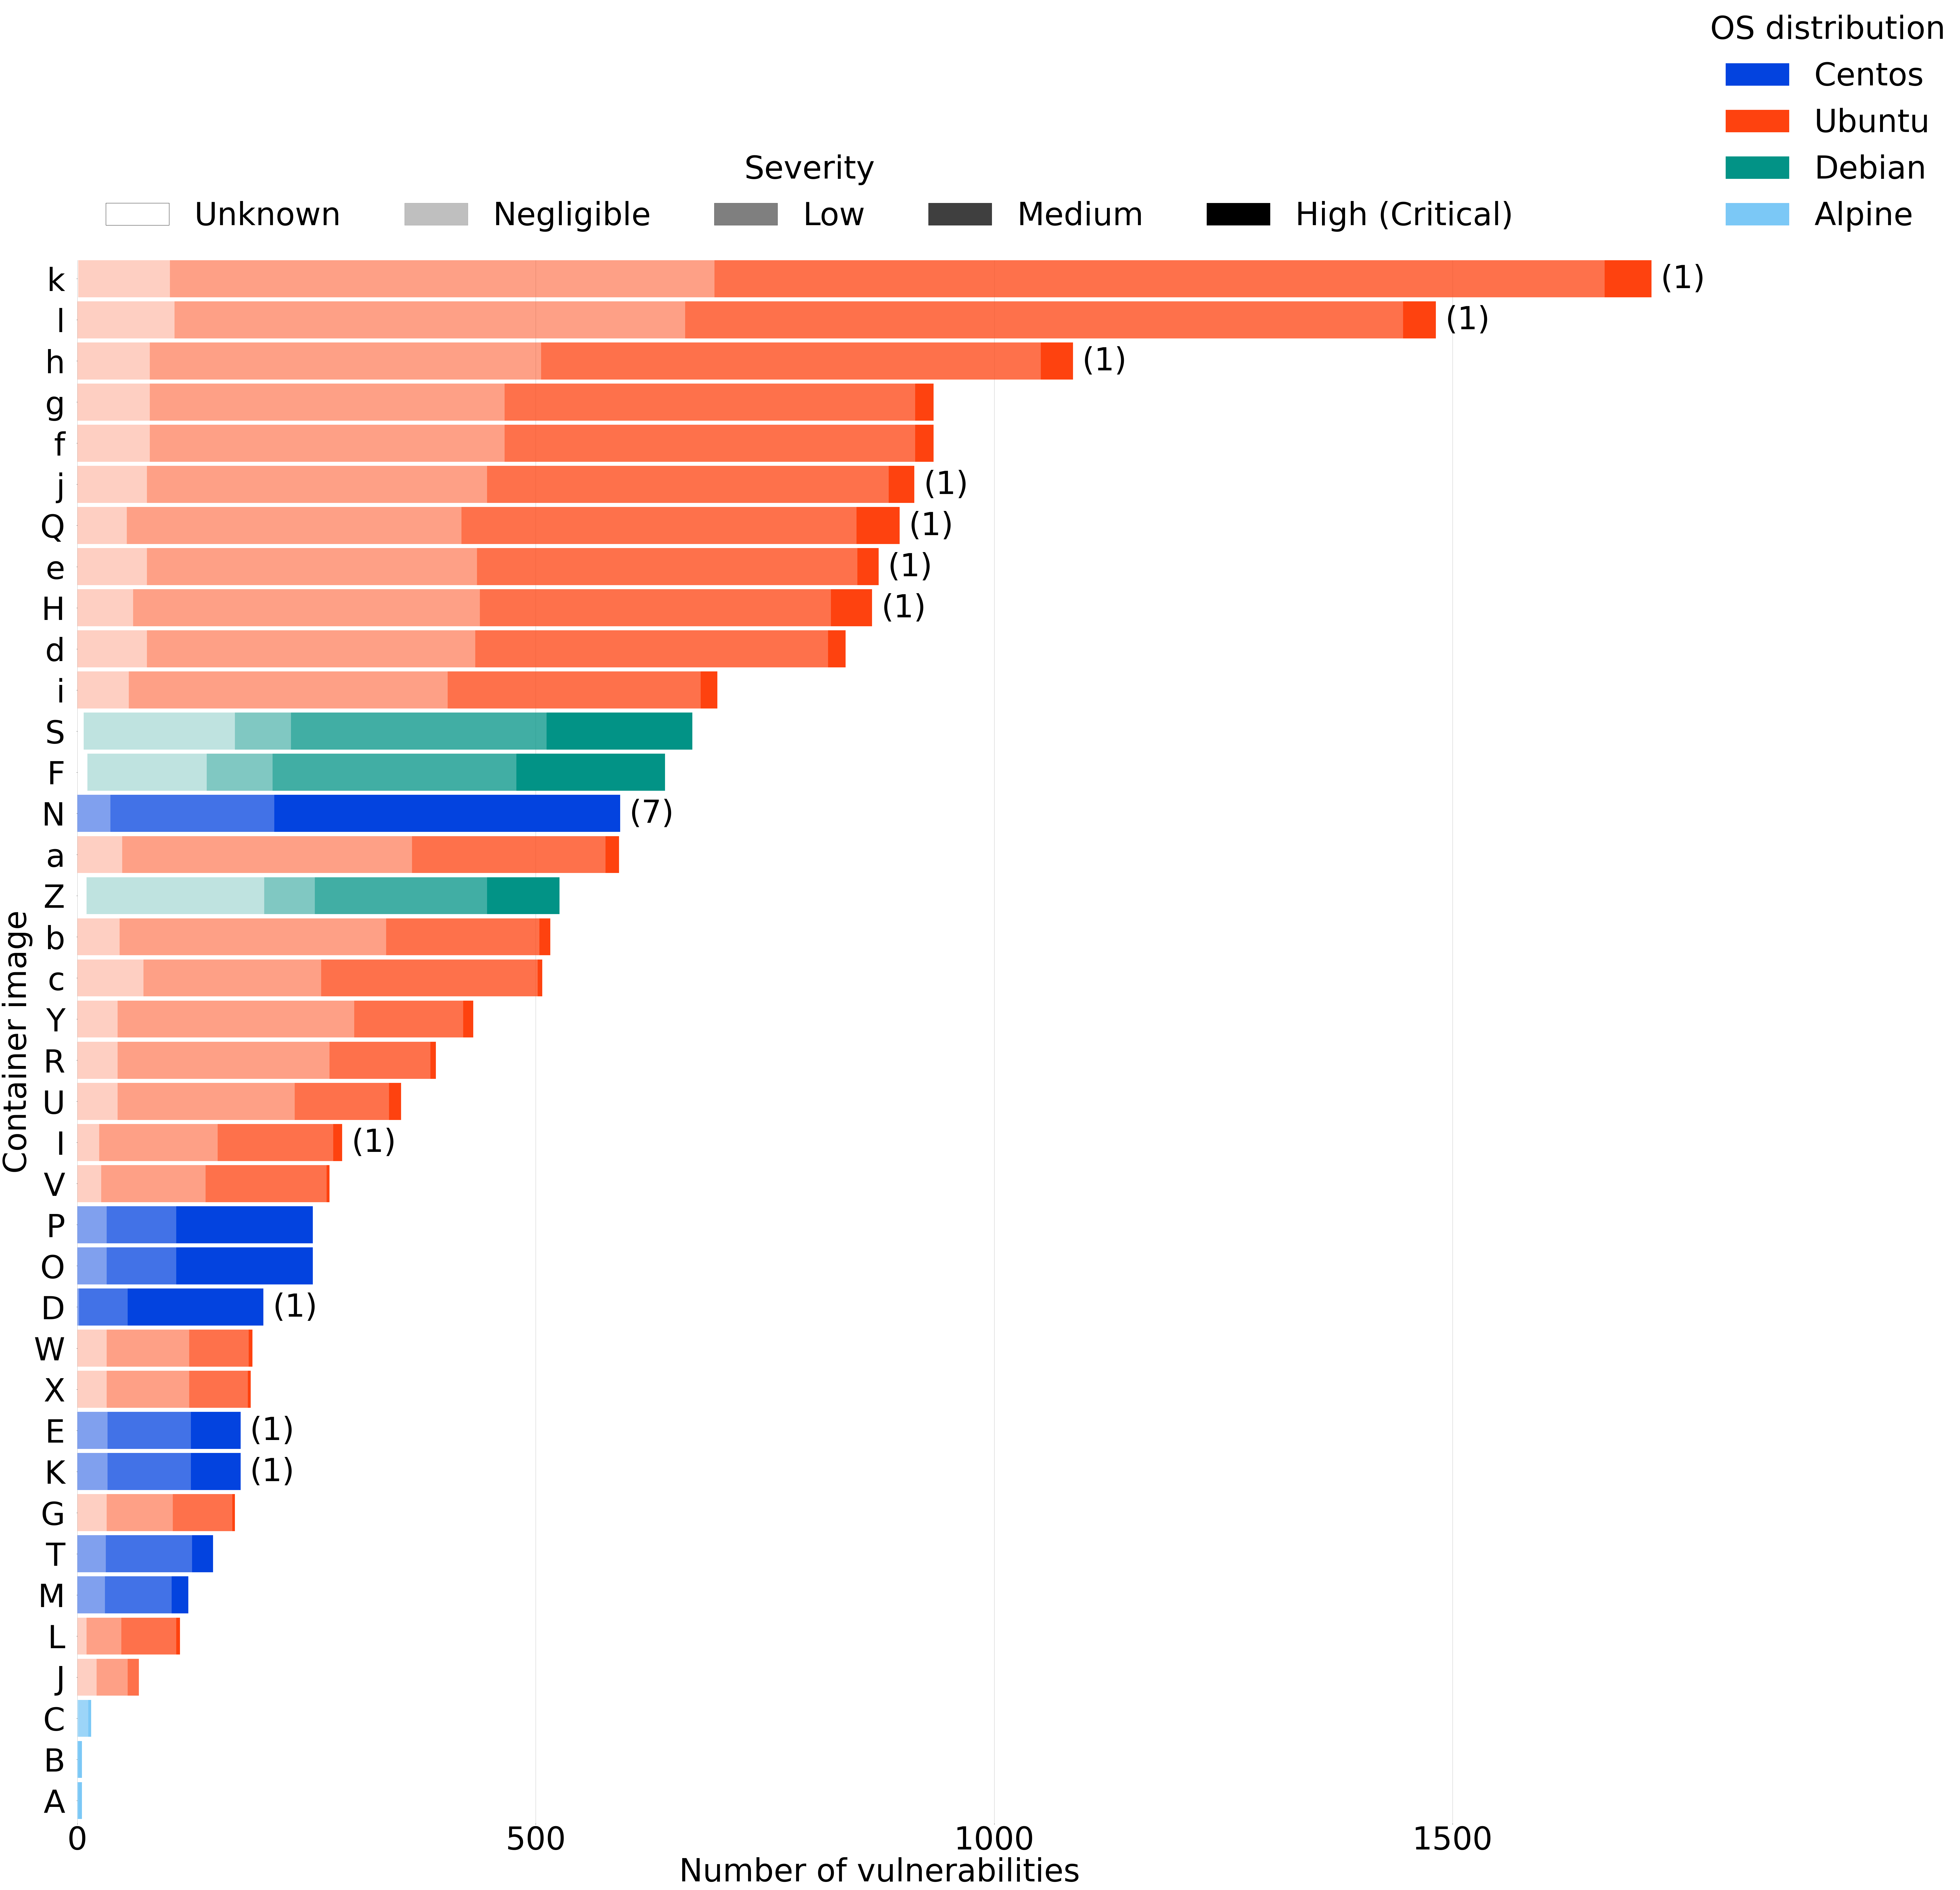

In [21]:
# Define font size
label_size = 110
font = {"size": label_size}
matplotlib.rc("font", **font)

fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(anchore_summary, ax)

plt.savefig("./Figures/by_status_anchore.pdf", bbox_inches="tight")
plt.show()

## Clair

The Clair overview isobtained from the same vul_plot function:

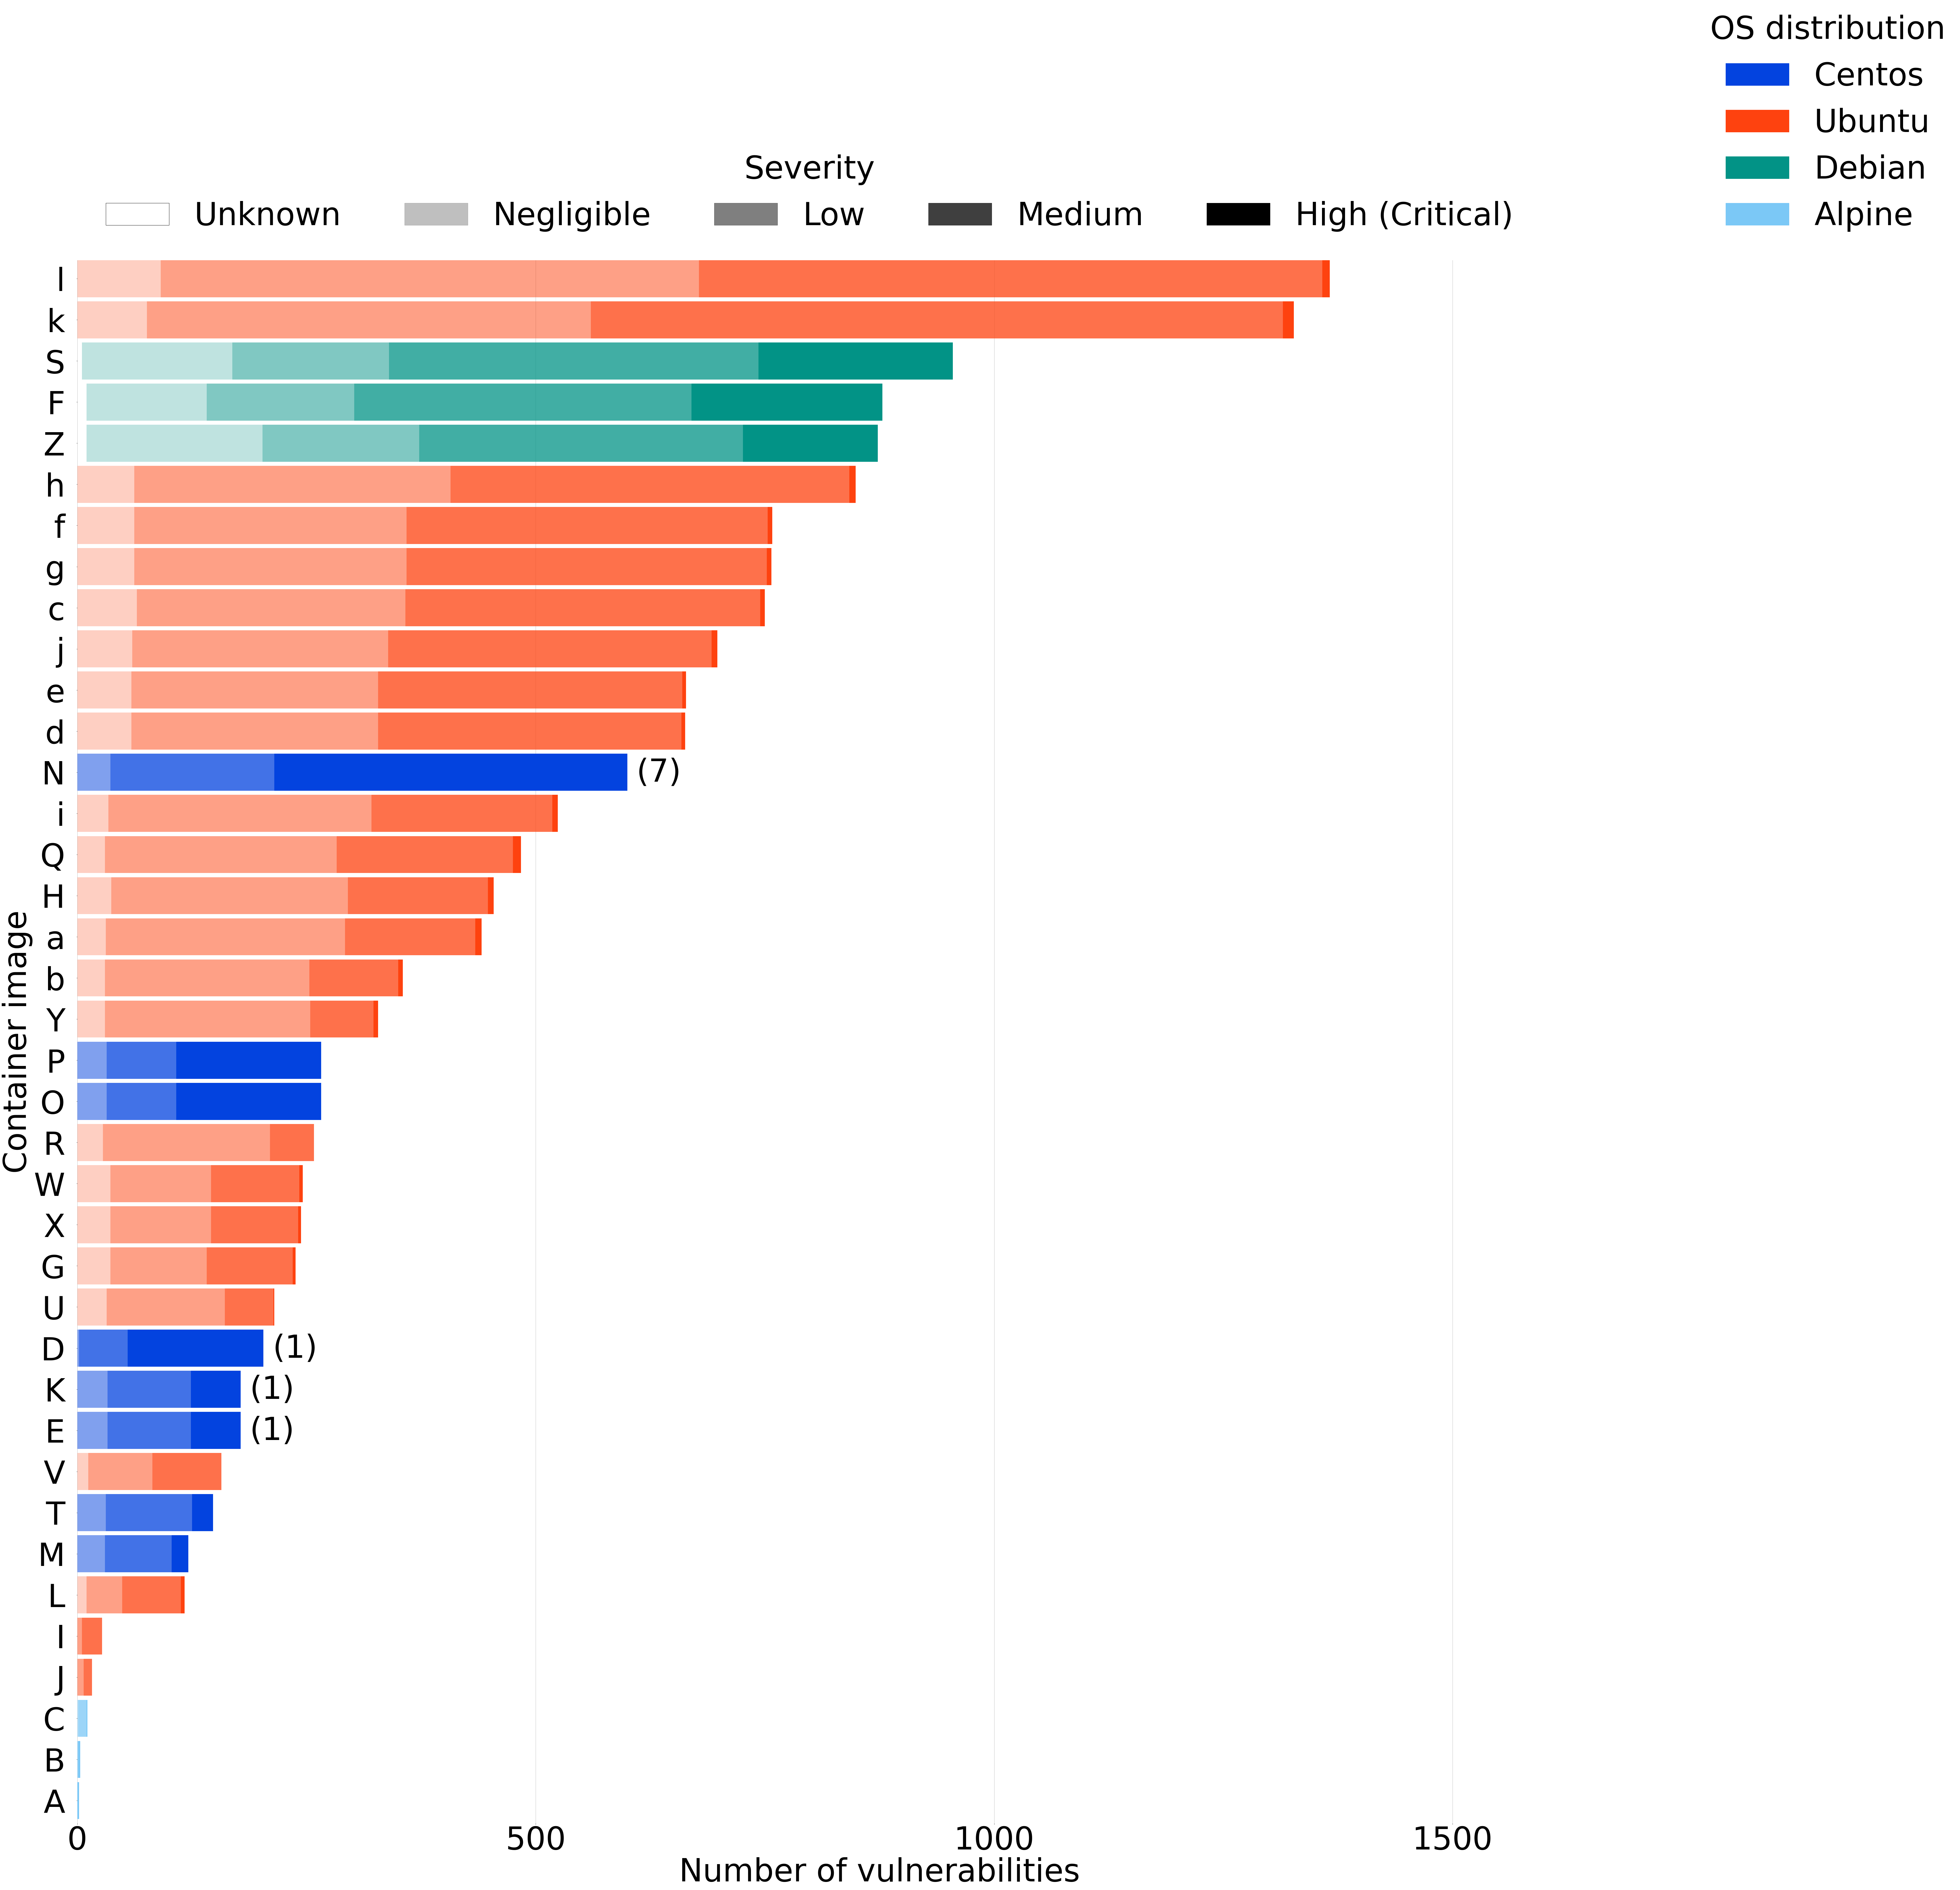

In [22]:
fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(clair_summary, ax)

plt.savefig("./Figures/by_status_clair.pdf", bbox_inches="tight")
plt.show()

Note: for brevity, this figure wasn't added to the paper. Although results are not identical to Anchore's, the trends remain consistent. Discrepancies between scanners are discussed in Section 4 of this notebook and in the paper.

## Vuls

Now, we can plot an overview of Vuls' results using the same function:

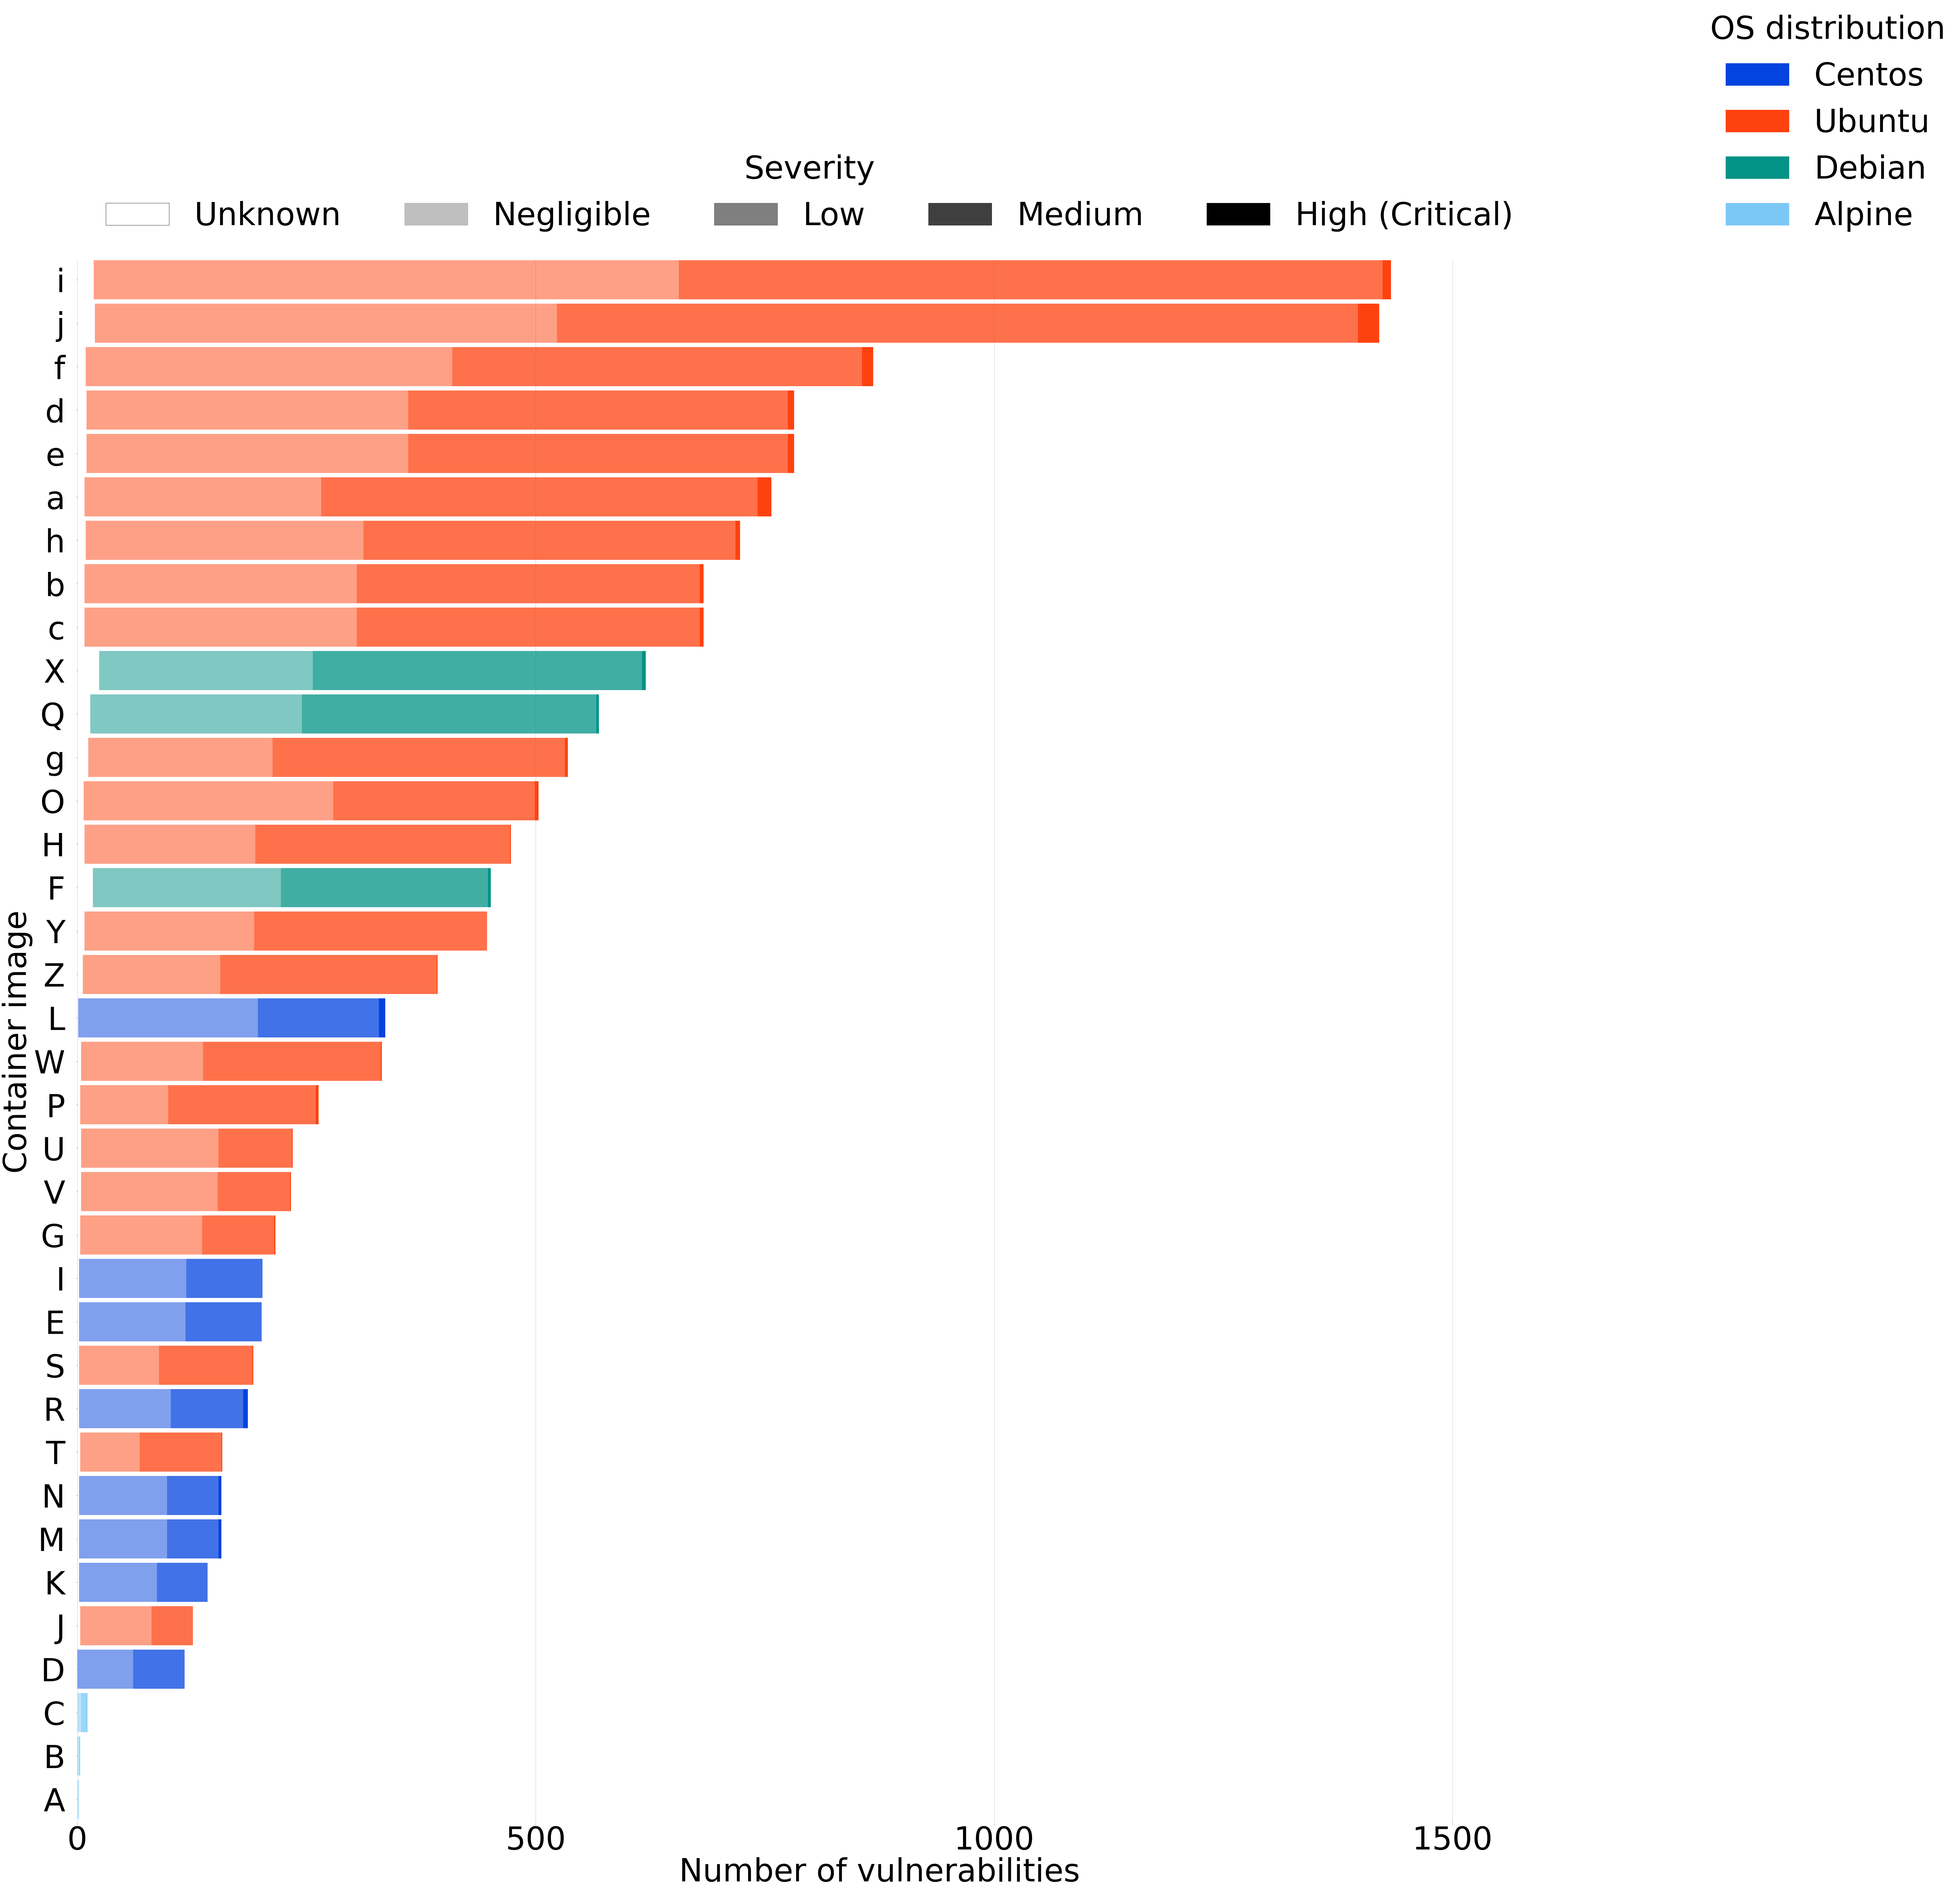

In [23]:
fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(vuls_summary, ax)

plt.savefig("./Figures/by_status_vuls.pdf", bbox_inches="tight")
plt.show()

## Stools

Finally, we can plot an overview of Stools results using the same function:

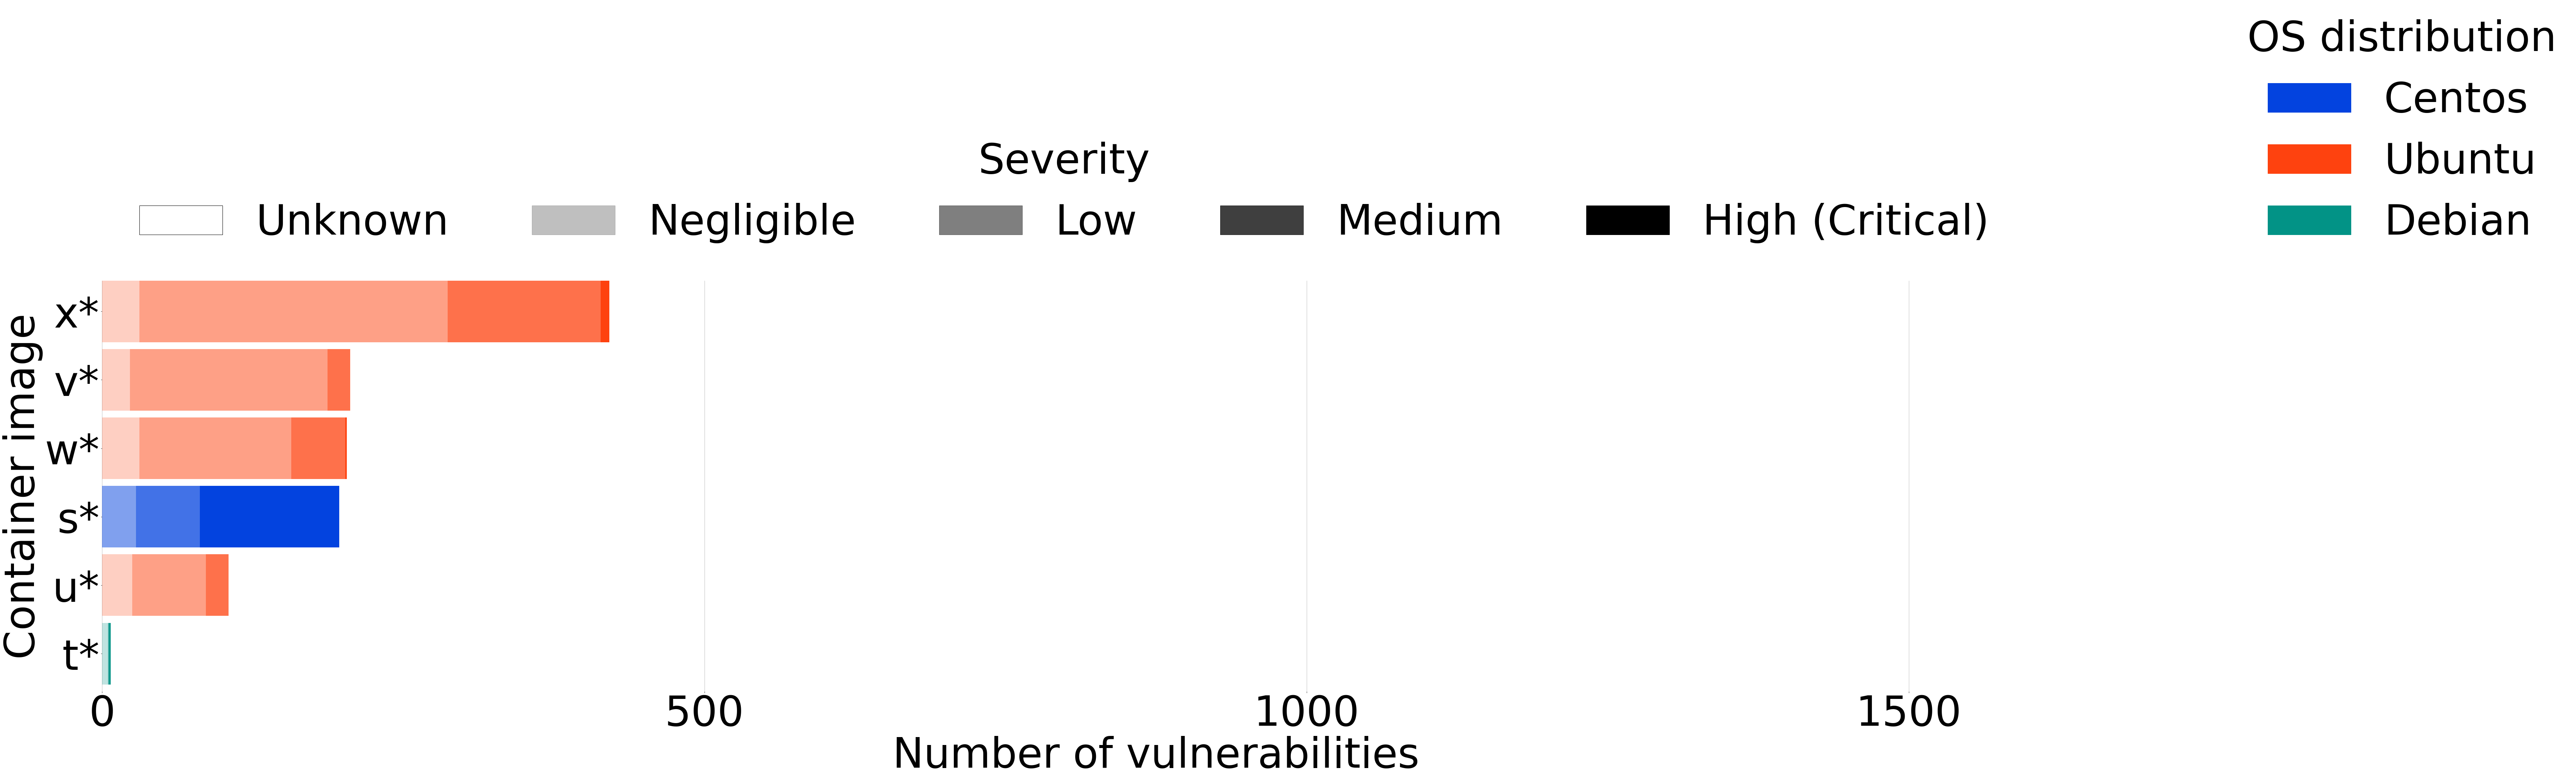

In [24]:
fig, ax = plt.subplots(figsize=(100, 20))
vul_plot(stools_summary, ax)

plt.savefig("./Figures/by_status_stools.pdf", bbox_inches="tight")
plt.show()

## Vulnerabilities by number of packages, before and after update

Here we plot the number of vulnerabilities vs the number of packages in the container image. We plot side by side the values obtained before and after package update and draw regression lines, to quantify the effect of package updates on the detected vulnerabilities.

We use colors to identify OS distributions, consistently with the previous plot.

In [25]:
def update_plot(
    df_summary: pd.DataFrame, ax: matplotlib.axes, ay: matplotlib.axes
) -> None:
    """
    Parameters
    ----------
    df: pandas.DataFrame
        Summary data frame to plot. Example: anchore_summary.
    ax: matplotlib.axes
        Axes where the graph before update will be plotted.
    ax: matplotlib.axes
        Axes where the graph after update will be plotted.

    Returns
    -------
    None
    """

    size = 10000  # marker size in the scatter plots

    packages = df_summary["Packages"].to_numpy()
    total = df_summary["Total"].to_numpy().astype(np.float)
    slope, intercept, r_value, p_value, std_err = linregress(packages, total)
    print(f"Before update: p={p_value}")
    ax.plot(packages, intercept + slope * packages, color="black", linewidth=3)
    ax.scatter(
        df_summary["Packages"],
        df_summary["Total"],
        s=size,
        color=df_summary["Color"],
        alpha=0.75,
        marker="o",
    )
    ax.text(
        700,
        1200,
        f"y={round(slope,1)}x-{abs(round(intercept,1))}\nr={round(r_value,2)}",
    )

    df1 = df_summary[df_summary.Total_after_update >= 0]  # filters None
    packages = df1["Packages"].to_numpy()
    total = df1["Total_after_update"].to_numpy().astype(np.float)
    slope, intercept, r_value, p_value, std_err = linregress(packages, total)
    print(f"After update: p={p_value}")
    ay.plot(packages, intercept + slope * packages, color="black", linewidth=3)
    ay.scatter(
        df_summary["Packages"],
        df_summary["Total_after_update"],
        s=size,
        color=df_summary["Color"],
        alpha=0.75,
        marker="o",
    )
    ay.text(
        700, 500, f"y={round(slope,1)}x-{abs(round(intercept,1))}\nr={round(r_value,2)}"
    )

    ymin = -50
    ymax = 1750
    xmin = 0
    xmax = 900
    for a in [ax, ay]:
        a.set_ylim(ymin, ymax)
        a.set_xlim(xmin, xmax)
        a.set_xlabel("Number of packages")

    ax.set_title("Before update")
    ax.set_ylabel("Number of vulnerabilities")
    ay.set_title("After update")

In [26]:
fig, (ax, ay) = plt.subplots(1, 2, figsize=(200, 100))
update_plot(combined_summary, ax, ay)
plt.savefig("./Figures/update.pdf", bbox_inches="tight")
plt.show()

Before update: p=9.052293242649708e-12
After update: p=1.9085624065573008e-08


## Vulnerabilities after minification

Here we plot a grouped bar chart where each group is associated with a container image that was minified. Each group has 3 bars: the first one represents the number of vulnerabilities after update, the second one is the number of vulnerabilities after minification, and the third one is the number of vulnerabilities after both operations were applied. We indicate the initial number of vulnerabilities in the image as a background frame.

Colors still represent OS distributions, consistently with the previous plots. Transparency now represent the operation applied to the image (update, minification, both operations, or none).

In [27]:
def minif_plot(df_summary, ax):
    """
    Parameters
    ----------
    df : the summary data frame to plot. Example: anchore_summary.
    ax: a matplotlib axes object where the graph will be plotted.

    Returns
    -------
    None
    """

    # Filter images that were both updated and minified
    df1 = df_summary[df_summary.Total_after_both >= 0][
        df_summary.Total_after_update >= 0
    ]

    width = 0.3  # width of the histogram bars

    ax.invert_yaxis()

    # Background rectangle representing the initial number of vulnerabilities (all severities)
    ax.barh(np.arange(5), df1["Total"], width, color=df1["Color"], alpha=0.1)
    ax.barh(np.arange(5) + width, df1["Total"], width, color=df1["Color"], alpha=0.1)
    ax.barh(
        np.arange(5) + width * 2, df1["Total"], width, color=df1["Color"], alpha=0.1
    )

    # Add a bar for each operation
    ax.barh(
        np.arange(5), df1["Total_after_update"], width, color=df1["Color"], alpha=0.25
    )
    ax.barh(
        np.arange(5) + width,
        df1["Total_after_minification"],
        width,
        color=df1["Color"],
        alpha=0.5,
    )
    ax.barh(
        np.arange(5) + 2 * width,
        df1["Total_after_both"],
        width,
        color=df1["Color"],
        alpha=0.75,
    )

    # Legend
    operations = ["None", "Update", "Minification", "Update & Minification"]

    patches = []
    for i in range(4):
        if i == 0:
            alpha = 0.1
        else:
            alpha = i / 4
        patches += [
            matplotlib.patches.Patch(color=(0, 0, 0, alpha), label=operations[i])
        ]

    ax.legend(
        handles=patches,
        bbox_to_anchor=(0.15, 1),
        ncol=5,
        loc="lower left",
        fontsize=label_size,
        title="Operation applied",
    )
    ax.legend_.set_frame_on(False)

    # Figure layout
    ax.set_yticklabels(df1["Abbrv"])
    ax.set_yticks(width + np.arange(5))

    ax.set_frame_on(False)

    ax.xaxis.grid()
    ax.xaxis.set_ticks([0, 500, 1000, 1500])
    ax.xaxis.set_ticks_position("bottom")
    ax.set_xlim(0, 1750)

    ax.set_ylabel("Container image")
    ax.set_xlabel("Number of vulnerabilities")

<ipython-input-27-d3bb578d8ac8>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_summary[df_summary.Total_after_both >= 0][
<ipython-input-27-d3bb578d8ac8>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df1["Abbrv"])


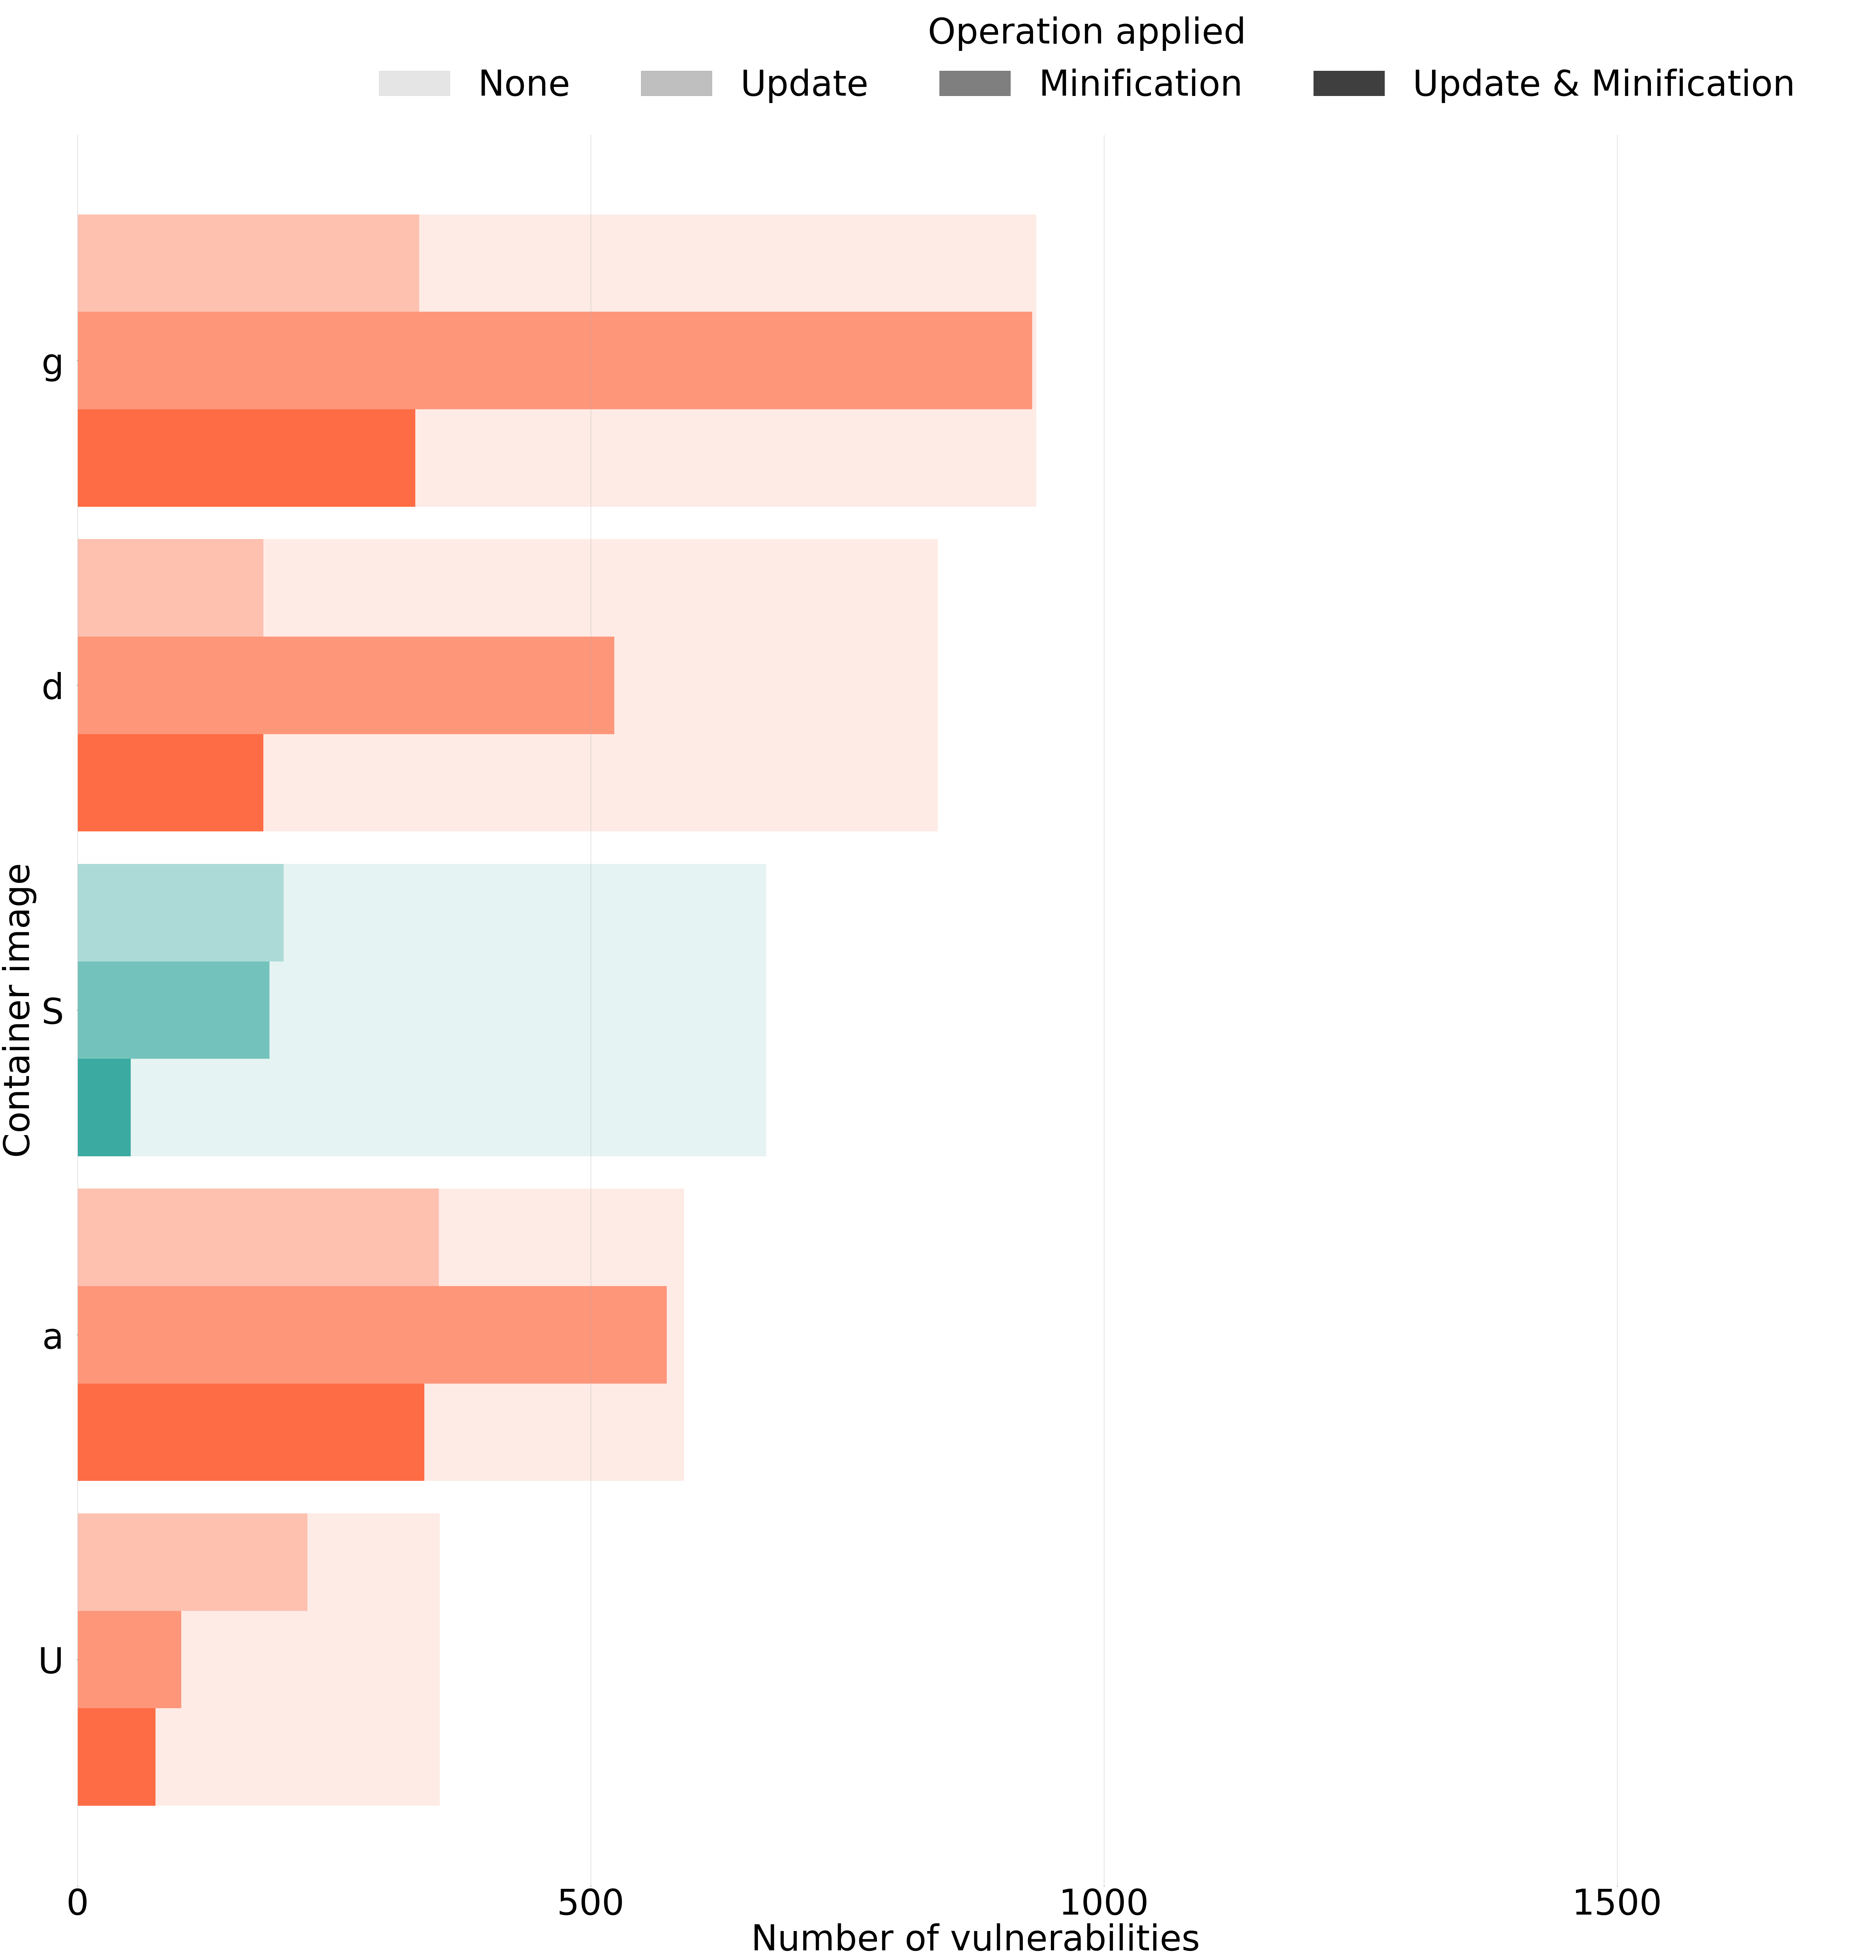

In [28]:
fig, ax = plt.subplots(figsize=(100, 100))
minif_plot(anchore_summary, ax)
plt.savefig("./Figures/update_and_minif.pdf", bbox_inches="tight")
plt.show()

## Putting all the figures together

We aggregate the previous figures in a single one (included in the paper), to provide a more compact overview of our results. We do this by creating 4 matplotlib axes and passing them to the functions defined previously:

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(200, 200))

# Add labels to sub-figures
label = ["A", "B", "C", "D"]
for i, ax in enumerate((axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1])):
    offset = 1.1
    ax.text(
        0,
        offset,
        label[i],
        transform=ax.transAxes,
        fontsize=200,
        fontweight="bold",
        va="top",
        ha="right",
    )
# Plot each subfigure in its axes object
vul_plot(combined_summary, axs[0, 0])
minif_plot(anchore_summary, axs[0, 1])
update_plot(combined_summary, axs[1, 0], axs[1, 1])
# This file is the one included in the paper
plt.savefig("./Figures/results.pdf", bbox_inches="tight")
plt.show()

<ipython-input-27-d3bb578d8ac8>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_summary[df_summary.Total_after_both >= 0][
<ipython-input-27-d3bb578d8ac8>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df1["Abbrv"])


Before update: p=9.052293242649708e-12
After update: p=1.9085624065573008e-08


# Comparison between scanners

As we saw previously, scanners provide slightly different results. Instead of repeating the previous figure once for each scanner, which would be lengthy and difficult to compare, we provide a compact comparison of results through a Venn diagram.

## Venn diagram

For each scanner, we get the actual set of vulnerabilities found in each container image:

In [30]:
severities = ["Negligible", "Low", "Medium", "High", "Critical", "Unknown"]

common_images = [x for x in vuls_files]  # all images were analyzed by Vuls

# print(len(common_images))
# For each scanner, build a set of vulnerabilities found in each image
vul_clair = {}
vul_anchore = {}
vul_vuls = {}

for image in common_images:  # pick only images that were processed by the 3 scanners
    clair_file = clair_files[image][0]
    anchore_file = anchore_files[image][0]
    vuls_file = vuls_files[image][0]
    # Fill clair vulnerabilities
    with open(clair_file, "r") as f:
        lines = f.readlines()
    cves = []
    check = False
    for line in lines:
        if line.startswith("+"):
            check = True
            break
    if not check:
        for line in lines:
            for status in severities:
                if status in line:
                    cves.append(line.split()[0])
    else:
        rows = [[str(x) for x in line.split("|")[:-1]] for line in lines]
        cols = [list(col) for col in zip(*rows)]
        for row in rows:
            if len(row) > 1:
                split_cve = row[2].split()
                if len(split_cve) > 1:
                    only_cve = split_cve[1]
                    severity = split_cve[0]
                    for status in severities:
                        if severity == status:
                            cves.append(only_cve)
    vul_clair[image] = set(cves)
    # Fill anchore vulnerabilities
    with open(anchore_file, "r") as f:
        lines = f.readlines()
    lines = [shlex.split(line) for line in lines][1:]
    vul_anchore[image] = set([l[0] for l in lines])
    # Fill vuls vulnerabilities
    with open(vuls_file, "r") as f:
        lines = [line.split() for line in f]
    cves = []
    for line in lines:
        if (line[0].startswith("CVE")) or (line[0].startswith("TEMP")):
            cves.append(line[0])
    vul_vuls[image] = set(cves)

For better referencing, we label each region of the Venn diagram (intersection between 1, 2 or 3 scanners) with an integer.
The following functions combined the vulnerability sets defined above and return the vulnerabilities in each region.

In [31]:
# Return variabilities in each region of the Venn diagram, for a given image
# Regions are numbered from top to bottom and from left to right
def region_1(image: str) -> Set[str]:
    return vul_anchore[image].difference(vul_clair[image]).difference(vul_vuls[image])


def region_2(image: str) -> Set[str]:
    return vul_anchore[image].difference(vul_vuls[image]).intersection(vul_clair[image])


def region_3(image: str) -> Set[str]:
    return vul_clair[image].difference(vul_anchore[image]).difference(vul_vuls[image])


def region_4(image: str) -> Set[str]:
    return vul_anchore[image].difference(vul_clair[image]).intersection(vul_vuls[image])


def region_5(image: str) -> Set[str]:
    return (
        vul_anchore[image].intersection(vul_clair[image]).intersection(vul_vuls[image])
    )


def region_6(image: str) -> Set[str]:
    return vul_vuls[image].difference(vul_anchore[image]).intersection(vul_clair[image])


def region_7(image: str) -> Set[str]:
    return vul_vuls[image].difference(vul_anchore[image]).difference(vul_clair[image])

We can now compute the number of vulnerabilities in each region by summing the sizes of the sets returned by the previous functions across all images.

In [32]:
# Compute sums of intersections, among all images
n_r_1 = sum([len(region_1(image)) for image in vuls_files])
n_r_2 = sum([len(region_2(image)) for image in vuls_files])
n_r_3 = sum([len(region_3(image)) for image in vuls_files])
n_r_4 = sum([len(region_4(image)) for image in vuls_files])
n_r_5 = sum([len(region_5(image)) for image in vuls_files])
n_r_6 = sum([len(region_6(image)) for image in vuls_files])
n_r_7 = sum([len(region_7(image)) for image in vuls_files])


# print Jaccard coefficients
d_anchore_clair = (n_r_2 + n_r_5) / (n_r_2 + n_r_5 + n_r_1 + n_r_3 + n_r_4 + n_r_6)
d_anchore_vuls = (n_r_4 + n_r_5) / (n_r_4 + n_r_5 + n_r_1 + n_r_2 + n_r_7 + n_r_6)
d_vuls_clair = (n_r_5 + n_r_6) / (n_r_5 + n_r_6 + n_r_2 + n_r_3 + n_r_4 + n_r_7)
print(f"Jaccard(Anchore,Clair)={round(d_anchore_clair, 2)}")
print(f"Jaccard(Anchore,Vuls)={round(d_anchore_vuls, 2)}")
print(f"Jaccard(Vuls, Clair)={round(d_vuls_clair, 2)}")

Jaccard(Anchore,Clair)=0.63
Jaccard(Anchore,Vuls)=0.59
Jaccard(Vuls, Clair)=0.8


We can finally draw the Venn diagram using 3 circles and 1 label per region:

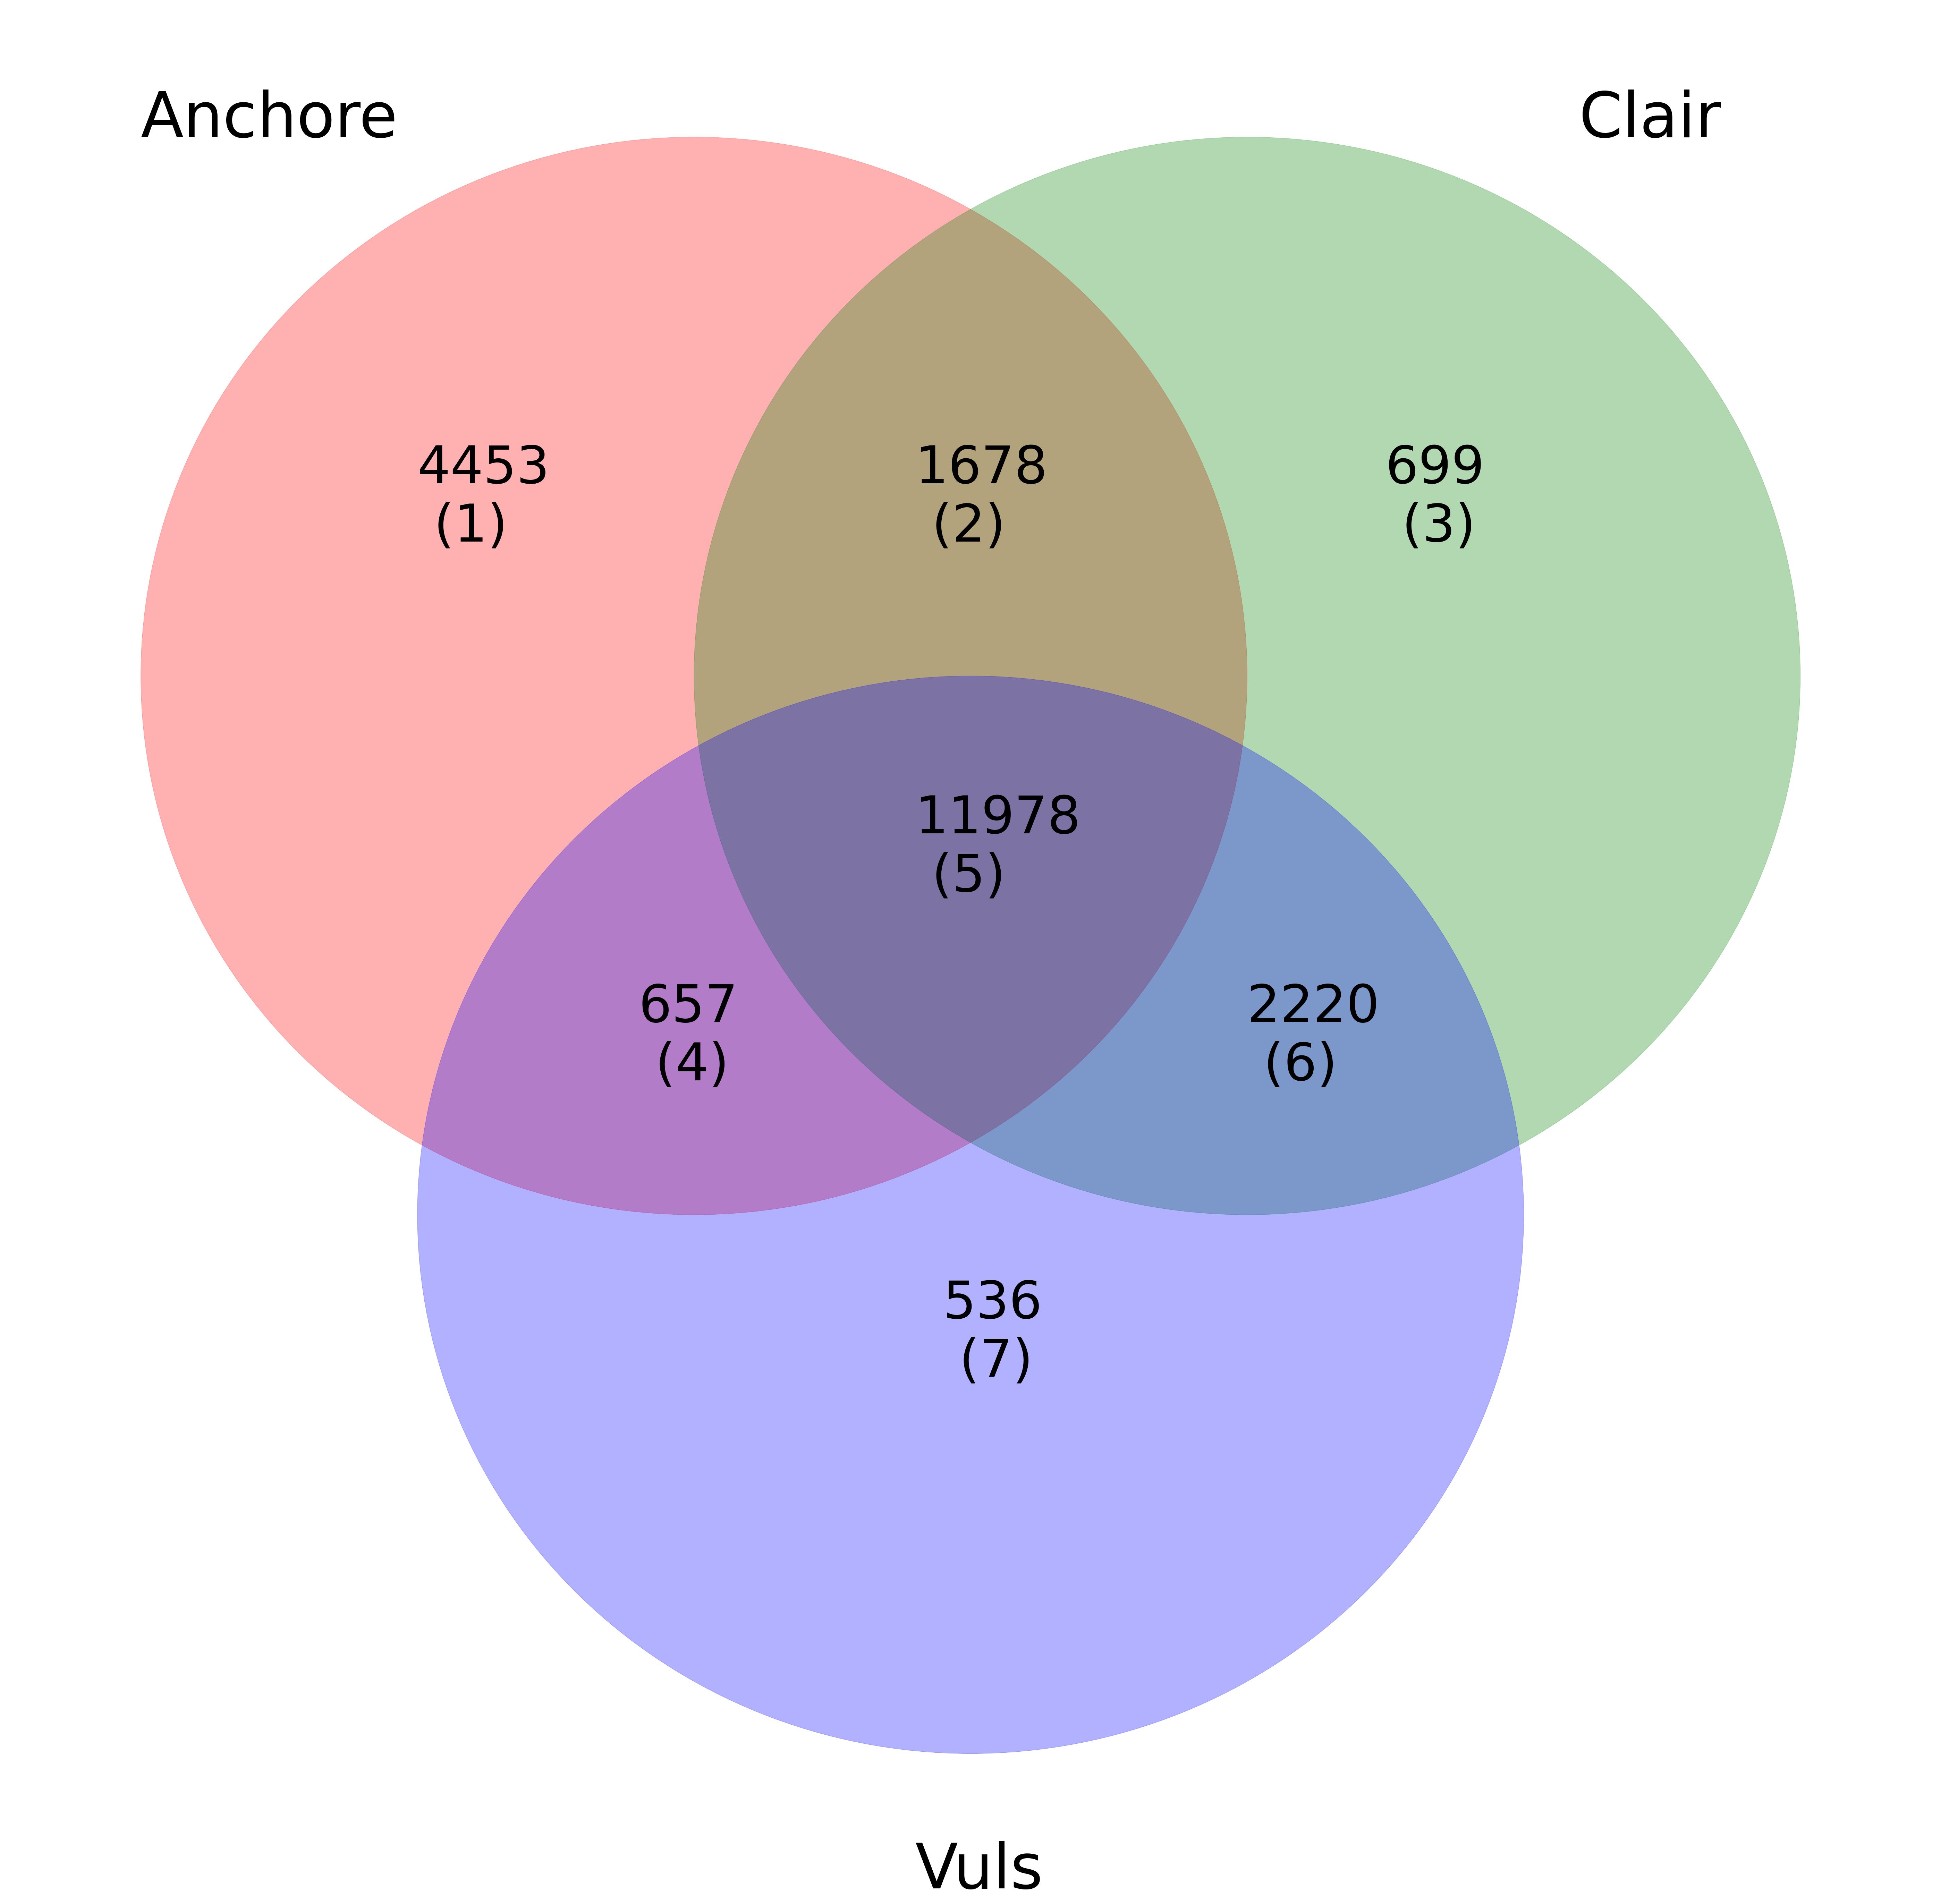

In [33]:
label_size = 150
figure, axes = plt.subplots(figsize=(100, 100))
alpha = 0.3
anchore_circle = plt.Circle((0.4, 0.6), 0.2, alpha=alpha, color="red")
clair_circle = plt.Circle((0.6, 0.6), 0.2, alpha=alpha, color="green")
vuls_circle = plt.Circle((0.5, 0.4), 0.2, alpha=alpha, color="blue")

axes.add_artist(anchore_circle)
axes.add_artist(clair_circle)
axes.add_artist(vuls_circle)

axes.text(0.3, 0.65, str(n_r_1) + "\n (1)", color="black", fontsize=label_size)
axes.text(0.48, 0.65, str(n_r_2) + "\n (2)", color="black", fontsize=label_size)
axes.text(0.65, 0.65, str(n_r_3) + "\n (3)", color="black", fontsize=label_size)
axes.text(0.38, 0.45, str(n_r_4) + "\n (4)", color="black", fontsize=label_size)
axes.text(0.48, 0.52, str(n_r_5) + "\n (5)", color="black", fontsize=label_size)
axes.text(0.6, 0.45, str(n_r_6) + "\n (6)", color="black", fontsize=label_size)
axes.text(0.49, 0.34, str(n_r_7) + "\n (7)", color="black", fontsize=label_size)

axes.text(0.2, 0.8, "Anchore", fontsize=1.2 * label_size)
axes.text(0.72, 0.8, "Clair", fontsize=1.2 * label_size)
axes.text(0.48, 0.15, "Vuls", fontsize=1.2 * label_size)

axes.set_xlim(0.15, 0.85)
axes.set_ylim(0.15, 0.85)

axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
axes.set_frame_on(False)

# This file is included in the paper
plt.savefig("./Figures/venn.pdf", bbox_inches="tight")

plt.show()

## Detailed analysis by region of the Venn diagram

Here we analyse the content of the Venn diagram region by region to better characterize the differences between scanners.

In [34]:
# Get details about all vulnerabilities in region 1
default_vuls = pd.DataFrame(columns=["Image", "CVE", "Package", "Severity"])
remaining_vuls = pd.DataFrame(columns=["Image", "CVE", "Package", "Severity"])
for image in common_images:
    default_cves = {}
    remaining_cves = {}
    file_name = anchore_files[image][0]
    with open(file_name, "r") as f:
        lines = f.readlines()
    for line in lines[1:]:
        s = shlex.split(line)
        cve = s[0]
        package = s[1]
        severity = s[2]
        if cve in region_1(image):
            if "linux-libc-dev" in package:
                default_cves[cve] = [package, severity]
            else:
                remaining_cves[cve] = [package, severity]

    for key, value in default_cves.items():
        cve = key
        package = value[0]
        severity = value[1]
        default_vuls = default_vuls.append(
            {
                "Image": image,
                "CVE": cve,
                "Package": default_cves[cve][0],
                "Severity": default_cves[cve][1],
            },
            ignore_index=True,
        )
    for key, value in remaining_cves.items():
        cve = key
        package = value[0]
        severity = value[1]
        remaining_vuls = remaining_vuls.append(
            {
                "Image": image,
                "CVE": cve,
                "Package": remaining_cves[cve][0],
                "Severity": remaining_cves[cve][1],
            },
            ignore_index=True,
        )
print("Vulnerabilities in Region 1 due to Linux-libc-dev package = ", len(default_vuls))
print("Anchore detects vulnerabilities in this package for both Ubuntu and Debian, whereas Clair detects this package vulnerabilities only in Debian and Vuls do not detect at all")

#remaining_vuls
print("Remaining vulnerabilities in Region 1 = ", len(remaining_vuls))
print("These vulnerabilities are actually present in source packages of the mentioned packages. Anchore detects that even if binary or subpackage of vulnerable package is present")

Vulnerabilities in Region 1 due to Linux-libc-dev package =  4443
Anchore detects vulnerabilities in this package for both Ubuntu and Debian, whereas Clair detects this package vulnerabilities only in Debian and Vuls do not detect at all
Remaining vulnerabilities in Region 1 =  10
These vulnerabilities are actually present in source packages of the mentioned packages. Anchore detects that even if binary or subpackage of vulnerable package is present


In [35]:
# Get details about all vulnerabilities detected only by Clair in Region 3
vulns_clair = pd.DataFrame(columns=["Image", "CVE", "Package", "Severity"])
severities = ["Unknown", "Negligible", "Low", "Medium", "High", "Critical"]
test = []
num = 0
linux_cves = []
for image in common_images:
    # print(image)
    clair_vuls = {}
    file_name = clair_files[image][0]
    with open(file_name, "r") as f:
        lines = f.readlines()
    cves = []
    check = False
    for line in lines:
        if line.startswith("+"):
            check = True
            break
    if not check:
        for line in lines[1:]:
            if line.split()[0] in region_3(image):
                clair_vuls[line.split()[0]] = [line.split()[1], line.split()[2]]
            # cves.append(line.split()[0])

    else:
        rows = [[str(x) for x in line.split("|")[:-1]] for line in lines]
        cols = [list(col) for col in zip(*rows)]
        for row in rows:
            if len(row) > 1:
                split_cve = row[2].split()
                if len(split_cve) > 1:
                    only_cve = split_cve[1]
                    severity = split_cve[0]
                    package = row[3]
                    for s in severities:
                        if severity == s:
                            if only_cve in region_3(image):
                                clair_vuls[only_cve] = [package, severity]
                        # cves.append(only_cve)
    # print(len(set(cves)))
    # num = num + len(set(cves))
    for key, value in clair_vuls.items():
        cve = key
        package = value[0]
        severity = value[1]
        vulns_clair = vulns_clair.append(
            {
                "Image": image,
                "CVE": cve,
                "Package": clair_vuls[cve][0],
                "Severity": clair_vuls[cve][1],
            },
            ignore_index=True,
        )
for index, row in vulns_clair.iterrows():
    if "linux" in row["Package"]:
        # print(row['Image'],"              ",row['CVE'],"            ",row['Package'])
        linux_cves.append(row["CVE"])
print("Vulnerabilities due to Linux package = ", len(linux_cves))

print("93 Linux package vulnerabilities are not detected by Anchore and Vuls as they are ignored by Debian")
print("573 vulnerabilties are wrong detections by Clair")
print("27 vulnerabilities are misssed by Anchore and Vuls(Anchore missed because they were not present in the database)")
print("3 rejected vulnerabilities by Debian")
print("3 vulnerabilities in Libav package are ignored by Debian and will not be patched")

Vulnerabilities due to Linux package =  93
93 Linux package vulnerabilities are not detected by Anchore and Vuls as they are ignored by Debian
573 vulnerabilties are wrong detections by Clair
27 vulnerabilities are misssed by Anchore and Vuls(Anchore missed because they were not present in the database)
3 rejected vulnerabilities by Debian
3 vulnerabilities in Libav package are ignored by Debian and will not be patched


In [36]:
# Get vulnerabilities of the region 7
vulns_vuls = pd.DataFrame(columns=["Image", "CVE", "Package", "Severity"])

for image in common_images:
    file_name = vuls_files[image][0]
    with open(file_name, "r") as f:
        lines = [line.split() for line in f]
    cves = []
    for line in lines:
        if (line[0].startswith("CVE")) or (line[0].startswith("TEMP")):
            if line[0] in region_7(image):
                cve = line[0]
                package = line[1]
                severity = line[3]
                vulns_vuls = vulns_vuls.append(
                    {
                        "Image": image,
                        "CVE": cve,
                        "Package": package,
                        "Severity": severity,
                    },
                    ignore_index=True,
                )

vulns_vuls
temp = []
for index, row in vulns_vuls.iterrows():
    #print(row["Image"], "              ", row["CVE"], "            ", row["Package"])
    if row["CVE"].startswith("TEMP"):
        temp.append(row["CVE"])
print("Vulnerabilities having TEMP identifier = ",len(temp))
print("These vulnerabilities have a temporary identifier and can be changed anytime so Anchore and Clair is not reporting them")
print("Remaining are mostly from Centos images and reason is unknown")

Vulnerabilities having TEMP identifier =  32
These vulnerabilities have a temporary identifier and can be changed anytime so Anchore and Clair is not reporting them
Remaining are mostly from Centos images and reason is unknown


In [37]:
# Get the vulnerabilities in region 6
vulns_vuls_clair = pd.DataFrame(
    columns=["Image", "CVE", "Package", "Version", "Severity"]
)

for image in common_images:
    file_name = vuls_files[image][0]
    with open(file_name, "r") as f:
        lines = [line.split() for line in f]
    cves = []
    for line in lines:
        if line[0].startswith("CVE"):
            if line[0] in region_6(image):
                cve = line[0]
                package = line[1]
                severity = line[3]
                version = line[2]
                vulns_vuls_clair = vulns_vuls_clair.append(
                    {
                        "Image": image,
                        "CVE": cve,
                        "Package": package,
                        "Version": version,
                        "Severity": severity,
                    },
                    ignore_index=True,
                )
cves_epoch = []
debian_false = []
debian_images = [
    "bids/mindboggle:0.0.4-1",
    "bids/nipypelines:0.3.0",
    "bids/hcppipelines:v3.17.0-18",
]
for index, row in vulns_vuls_clair.iterrows():
    if ":" in row["Version"]:
        cves_epoch.append(row["CVE"])
    else:
        if row["Image"] in debian_images:
            debian_false.append(row["CVE"])
print("Due to Epoch Bug = ", len(cves_epoch))
print(
    "Anchore filters vulnerabilities which are marked by Debian as Minor = ",
    len(debian_false),
)
print("Remaining have Ignored status in Ubuntu = 383")

Due to Epoch Bug =  1271
Anchore filters vulnerabilities which are marked by Debian as Minor =  566
Remaining have Ignored status in Ubuntu = 383


In [38]:
# Get vulnerabilities on region 4 of the Venn diagram
vulns_vuls_anchore = pd.DataFrame(
    columns=["Image", "CVE", "Package", "Version", "Severity"]
)

for image in common_images:
    file_name = vuls_files[image][0]
    with open(file_name, "r") as f:
        lines = [line.split() for line in f]
    for line in lines:
        if line[0].startswith("CVE"):
            if line[0] in region_4(image):
                cve = line[0]
                package = line[1]
                severity = line[3]
                version = line[2]
                vulns_vuls_anchore = vulns_vuls_anchore.append(
                    {
                        "Image": image,
                        "CVE": cve,
                        "Package": package,
                        "Version": version,
                        "Severity": severity,
                    },
                    ignore_index=True,
                )
cves = []
for index, row in vulns_vuls_anchore.iterrows():
    cves.append(row["CVE"])
print("Total vulnerabilities in region 4 = ", len(cves))
print("These vulnerabilities should have reported by Clair")
print("These are all vulnerabilities in Ubuntu")
print("These vulnerabilities are not detected by Clair because either they have status DNE in Ubuntu 14.04 ESM or exist in Ubuntu 16.04")

Total vulnerabilities in region 4 =  657
These vulnerabilities should have reported by Clair
These are all vulnerabilities in Ubuntu
These vulnerabilities are not detected by Clair because either they have status DNE in Ubuntu 14.04 ESM or exist in Ubuntu 16.04


In [39]:
# Get vulnerabilities in region 2 of the Venn diagram
vulns_clair_anchore = pd.DataFrame(columns=["Image", "CVE", "Package", "Severity"])

for image in common_images:
    file_name = anchore_files[image][0]
    with open(file_name, "r") as f:
        lines = f.readlines()
    cves = {}
    for line in lines[1:]:
        s = shlex.split(line)
        cve = s[0]
        package = s[1]
        severity = s[2]
        if cve in region_2(image):
            cves[cve] = [package, severity]

    for key, value in cves.items():
        cve = key
        package = value[0]
        severity = value[1]
        vulns_clair_anchore = vulns_clair_anchore.append(
            {"Image": image, "CVE": cve, "Package": package, "Severity": severity},
            ignore_index=True,
        )
print("Total vulnerabilities in region 2 = ", len(vulns_clair_anchore))

packages = set()
linux_package = []
kernel_package = []
for index, row in vulns_clair_anchore.iterrows():
    packages.add(row["Package"])
    if "linux-libc-dev" in row["Package"]:
        linux_package.append(row["CVE"])
    if "kernel-headers" in row["Package"]:
        kernel_package.append(row["CVE"])
remaining = len(vulns_clair_anchore) - (len(linux_package) + len(kernel_package))
print("Vulnerabilities in Linux-libc-dev Package = ", len(linux_package),". Vuls do not report vulnerabilities in Linux-libc-dev package")
print("Vulnerabilities in Kernel-headers package = ", len(kernel_package))
print("Remaining vulnerabilities = ", remaining)
print("These all vulnerabilities should have been reported by Vuls")

Total vulnerabilities in region 2 =  1678
Vulnerabilities in Linux-libc-dev Package =  987 . Vuls do not report vulnerabilities in Linux-libc-dev package
Vulnerabilities in Kernel-headers package =  632
Remaining vulnerabilities =  59
These all vulnerabilities should have been reported by Vuls
